## Ajustes iniciais

In [1]:
#@title 1. Preparar Ambiente Colab (Instalações e Clonagem)

# Montar Google Drive (opcional, ajuste o caminho depois se necessário)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# Instalar bibliotecas Python
!pip install netCDF4 pandas matplotlib scipy

# Instalar GDAL e seus bindings Python
!apt update && apt install gdal-bin python3-gdal libgdal-dev -y
import os
os.environ['CPL_ZIP_ENCODING'] = 'UTF-8'
os.environ['PROJ_LIB'] = '/usr/share/proj' # Ajuste se necessário, mas este é comum para Colab

# Verificar se o gdal pode ser importado
try:
    from osgeo import gdal, ogr, osr
    print(f"GDAL {gdal.VersionInfo('RELEASE_NAME')} e OGR/OSR importados com sucesso.")
except Exception as e:
    print(f"Erro ao importar GDAL: {e}")
    print("Pode ser necessário reiniciar o ambiente de execução após a instalação do apt.")

# Importar numpy (será usado nos scripts)
import numpy as np
print(f"NumPy {np.__version__} importado.")

# Clonar o repositório gespinoza/hants
!git clone https://github.com/gespinoza/hants.git

# Mudar para o diretório do repositório ou adicionar ao path
# Vamos adicionar ao path para que os módulos sejam encontráveis
import sys
# O repositório gespinoza/hants pode ter uma estrutura como /hants/hants (módulo) e /hants/davgis
# Ou main.py pode estar na raiz /hants e davgis como /hants/davgis
# Após clonar, a pasta principal é /content/hants/
# Se main.py e davgis/ são diretamente dentro de /content/hants/:
sys.path.insert(0, '/content/hants')
print("Repositório 'hants' clonado e '/content/hants' adicionado ao sys.path.")
print("Conteúdo de /content/hants:")
!ls /content/hants

Mounted at /content/drive
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
81 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.ill

In [2]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

###Atualizações no código original

In [3]:
#@title DEBUG: davgis/functions.py (Versão Python 3 com Prints de Depuração)

import os
# Garante que a pasta davgis exista (o clone do git já deve tê-la criado)
# Isso é importante se esta célula for rodada independentemente ou antes da clonagem em algum teste.
# No fluxo normal, a Célula 1 já clona e cria a estrutura.
os.makedirs('/content/hants/davgis', exist_ok=True)

functions_py_content_debug = """
# -*- coding: utf-8 -*-
# davgis/functions.py (COM PRINTS DE DEBUG ADICIONADOS)
import os
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

import pandas as pd
import numpy as np
import netCDF4
import math
import warnings
from scipy.interpolate import griddata

# ... (As funções Buffer, Feature_to_Raster, List_Fields que você não está usando diretamente no HANTS podem ser omitidas aqui para economizar espaço na resposta, OU mantidas como estavam na versão Python 3 adaptada)
# Vamos focar nas funções críticas para HANTS, adicionando prints.

def Raster_to_Array(input_tiff, ll_corner, x_ncells, y_ncells,
                    values_type='float32'):
    print(f"        [davgis.Raster_to_Array] Abrindo: {input_tiff}")
    give_warning = False
    inp_ds = gdal.Open(input_tiff, gdal.GA_ReadOnly)
    if inp_ds is None:
        warnings.warn(f"        [davgis.Raster_to_Array] ERRO: Não foi possível abrir o raster de entrada: {input_tiff}")
        # Retorna um array de NaNs com o shape esperado se não conseguir abrir
        return np.full((y_ncells, x_ncells), np.nan, dtype=np.dtype(values_type))

    inp_transform = inp_ds.GetGeoTransform()
    inp_band = inp_ds.GetRasterBand(1)

    top_left_x_raster = inp_transform[0]
    cellsize_x_raster = inp_transform[1]
    top_left_y_raster = inp_transform[3]
    cellsize_y_raster = inp_transform[5]
    NoData_value_raster = inp_band.GetNoDataValue()

    x_total_pixels_raster = inp_ds.RasterXSize
    y_total_pixels_raster = inp_ds.RasterYSize

    print(f"        [davgis.Raster_to_Array] Info Raster Entrada ('{os.path.basename(input_tiff)}'):")
    print(f"            GeoTransform: {inp_transform}")
    print(f"            Dimensões: {x_total_pixels_raster}x{y_total_pixels_raster} pixels")
    print(f"            NoData Value: {NoData_value_raster}")
    print(f"        [davgis.Raster_to_Array] Parâmetros da Grade de Saída Desejada:")
    print(f"            ll_corner (xmin, ymin): {ll_corner}")
    print(f"            x_ncells (cols): {x_ncells}, y_ncells (rows): {y_ncells}")


    xmin_array = ll_corner[0]
    ymin_array = ll_corner[1]

    x_offset_read = int(round((xmin_array - top_left_x_raster) / cellsize_x_raster))
    y_offset_read = int(round((top_left_y_raster - (ymin_array + y_ncells * abs(cellsize_y_raster))) / abs(cellsize_y_raster)))

    print(f"        [davgis.Raster_to_Array] Offsets calculados para leitura (no raster): x_offset={x_offset_read}, y_offset={y_offset_read}")

    final_array = np.full((y_ncells, x_ncells), np.nan, dtype=np.dtype(values_type))

    src_x_start = max(0, x_offset_read)
    src_y_start = max(0, y_offset_read)

    dst_x_start = 0
    if x_offset_read < 0: dst_x_start = -x_offset_read

    dst_y_start = 0
    if y_offset_read < 0: dst_y_start = -y_offset_read

    win_x_size = min(x_ncells - dst_x_start, x_total_pixels_raster - src_x_start)
    win_y_size = min(y_ncells - dst_y_start, y_total_pixels_raster - src_y_start)

    win_x_size = max(0, win_x_size)
    win_y_size = max(0, win_y_size)

    print(f"        [davgis.Raster_to_Array] Janela de Leitura (src): x_start={src_x_start}, y_start={src_y_start}, x_size={win_x_size}, y_size={win_y_size}")
    print(f"        [davgis.Raster_to_Array] Janela de Escrita (dst no array final): x_start={dst_x_start}, y_start={dst_y_start}")


    if win_x_size > 0 and win_y_size > 0:
        array_read = inp_band.ReadAsArray(src_x_start, src_y_start, win_x_size, win_y_size)
        array_read = array_read.astype(np.dtype(values_type))

        # Debug: verificar o array lido antes de tratar NoData
        if array_read.size > 0:
            print(f"        [davgis.Raster_to_Array] array_read bruto (antes de NoData): Min={np.nanmin(array_read):.4f}, Max={np.nanmax(array_read):.4f}, Média={np.nanmean(array_read):.4f}")
        else:
            print(f"        [davgis.Raster_to_Array] array_read bruto está vazio.")


        if NoData_value_raster is not None:
            if np.isnan(NoData_value_raster):
                # Se NoData já é NaN, não precisa fazer nada aqui se o dtype for float
                print(f"        [davgis.Raster_to_Array] NoData do raster é NaN. Mantendo NaNs.")
            else:
                print(f"        [davgis.Raster_to_Array] Convertendo NoData do raster ({NoData_value_raster}) para np.nan.")
                array_read[np.isclose(array_read, NoData_value_raster)] = np.nan

        # Colar os dados lidos no array final na posição correta
        final_array[dst_y_start : dst_y_start + win_y_size,
                    dst_x_start : dst_x_start + win_x_size] = array_read

        if dst_x_start > 0 or dst_y_start > 0 or \
           (dst_x_start + win_x_size) < x_ncells or \
           (dst_y_start + win_y_size) < y_ncells:
            give_warning = True
    else:
        give_warning = True
        print(f"        [davgis.Raster_to_Array] AVISO: Nenhuma sobreposição para leitura (win_x_size ou win_y_size <= 0).")


    if give_warning:
        warnings.warn('[davgis.Raster_to_Array] A área solicitada para o array está parcial ou totalmente fora da extensão do raster. ' +
                      'Partes não sobrepostas foram preenchidas com NaNs.')

    # Debug: verificar o array final
    valid_final_pixels = final_array[~np.isnan(final_array)]
    if valid_final_pixels.size > 0:
        print(f"        [davgis.Raster_to_Array] final_array (após colar): Min={np.min(valid_final_pixels):.4f}, Max={np.max(valid_final_pixels):.4f}, N_valid={valid_final_pixels.size}")
    else:
        print(f"        [davgis.Raster_to_Array] AVISO: final_array (após colar) só contém NaNs.")

    inp_ds = None
    return final_array

# --- As outras funções do davgis/functions.py (Resample, Clip, NetCDF_to_Raster, etc.) ---
# Cole aqui a versão Python 3 adaptada delas, como na Célula 2 da resposta com timestamp 2024-05-14 16:15:20 UTC
# Se elas não mudaram, não precisa repetir, mas garanta que estão no functions_py_content_debug
# Por brevidade, vou omiti-las aqui, mas elas DEVEM estar no functions_py_content_debug

# Copie e cole AQUI o restante do functions.py adaptado da resposta anterior,
# começando por 'def Resample(...)' até o final de 'def gdaltype_from_dtype(...)'
# É importante que todas as funções que o main.py (hants_main_runner.py) usa
# (Spatial_Reference, Raster_to_Array, NetCDF_to_Raster) estejam aqui e corretas.

# Vou adicionar as versões adaptadas das outras funções necessárias pelo main.py:
def Spatial_Reference(epsg, return_string=True):
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(int(epsg)) # EPSG deve ser int
    if return_string:
        return srs.ExportToWkt()
    else:
        return srs

def List_Datasets(path, ext): # Esta função não é mais usada ativamente na create_netcdf adaptada
    datsets_ls = []
    if not ext.startswith('.'):
        ext_with_dot = '.' + ext.lower()
    else:
        ext_with_dot = ext.lower()
    for f_name in os.listdir(path):
        if os.path.splitext(f_name)[1].lower() == ext_with_dot:
            datsets_ls.append(f_name)
    return datsets_ls

def NetCDF_to_Raster(input_nc, output_tiff, ras_variable,
                     x_variable='longitude', y_variable='latitude',
                     crs={'variable': 'crs', 'wkt': 'spatial_ref'}, time=None): # Ajustado crs wkt key
    inp_nc_ds = netCDF4.Dataset(input_nc, 'r')
    inp_values_var = inp_nc_ds.variables[ras_variable]

    dim_names = inp_values_var.dimensions
    try:
        x_dim_name = x_variable
        y_dim_name = y_variable
    except ValueError:
        raise ValueError(f"Variáveis de dimensão x ('{x_variable}') ou y ('{y_variable}') não encontradas nas dimensões de '{ras_variable}' ({dim_names})")

    inp_array_2d_slice = None
    if not time:
        if len(inp_values_var.shape) == 2:
             inp_array_2d_slice = inp_values_var[:]
        elif len(inp_values_var.shape) == 3 and inp_values_var.shape[0] == 1:
             inp_array_2d_slice = inp_values_var[0,:,:]
        else:
             raise ValueError(f"A variável '{ras_variable}' tem {len(inp_values_var.shape)} dimensões. Esperado 2, ou 3 com tempo especificado e dimensão de tempo sendo 1.")
    else:
        if len(inp_values_var.shape) != 3:
            raise ValueError(f"Variável '{ras_variable}' não é 3D como esperado quando 'time' é especificado.")

        time_dim_name_in_var = time['variable']
        time_value_to_find = time['value']

        if time_dim_name_in_var not in dim_names:
            raise ValueError(f"Dimensão de tempo '{time_dim_name_in_var}' não encontrada nas dimensões de '{ras_variable}' ({dim_names})")
        if time_dim_name_in_var not in inp_nc_ds.variables:
            raise ValueError(f"Variável de tempo '{time_dim_name_in_var}' não encontrada no NetCDF.")

        time_data_array = inp_nc_ds.variables[time_dim_name_in_var][:]

        try:
            if np.issubdtype(type(time_value_to_find), np.number) and np.issubdtype(time_data_array.dtype, np.number):
                 time_index_matches = np.where(np.isclose(time_data_array, time_value_to_find))[0]
            else:
                 time_index_matches = np.where(time_data_array == time_value_to_find)[0]

            if len(time_index_matches) == 0:
                raise ValueError(f"Valor de tempo '{time_value_to_find}' não encontrado na variável de tempo '{time_dim_name_in_var}'. Primeiros valores: {time_data_array[:10]}...")
            time_index = time_index_matches[0]
        except Exception as e:
            raise ValueError(f"Erro ao encontrar o índice de tempo para valor '{time_value_to_find}': {e}")

        slicer = [slice(None)] * 3
        var_dims_order = inp_values_var.dimensions
        time_axis_idx = var_dims_order.index(time_dim_name_in_var)
        slicer[time_axis_idx] = time_index
        inp_array_2d_slice = inp_values_var[tuple(slicer)]

    if inp_array_2d_slice is None:
        raise Exception("Não foi possível extrair o array 2D do NetCDF.")

    gdal_datatype_gdalenum = gdaltype_from_dtype(inp_array_2d_slice.dtype)

    NoData_value_to_set = -9999.0
    if hasattr(inp_values_var, '_FillValue'):
        NoData_value_attr = inp_values_var._FillValue
        if isinstance(NoData_value_attr, (np.ndarray, list)):
            NoData_value_to_set = NoData_value_attr.item(0) if len(NoData_value_attr) > 0 else -9999.0
        else:
            NoData_value_to_set = NoData_value_attr

        if isinstance(NoData_value_to_set, np.generic):
            NoData_value_to_set = NoData_value_to_set.item()

        if 'float' in inp_array_2d_slice.dtype.name:
            NoData_value_to_set = float(NoData_value_to_set)
        else:
            NoData_value_to_set = int(NoData_value_to_set)
    else:
        # warnings.warn(f"Variável '{ras_variable}' não tem atributo _FillValue. Usando {NoData_value_to_set} como NoData.")
        if 'float' not in inp_array_2d_slice.dtype.name:
             NoData_value_to_set = int(NoData_value_to_set)

    if isinstance(crs, str):
        srs_wkt_final = crs
    else:
        crs_variable_name_in_nc = crs['variable']
        crs_wkt_attribute_name = crs['wkt']

        if crs_variable_name_in_nc not in inp_nc_ds.variables:
            raise ValueError(f"Variável CRS '{crs_variable_name_in_nc}' não encontrada no NetCDF.")
        crs_var_obj = inp_nc_ds.variables[crs_variable_name_in_nc]
        if not hasattr(crs_var_obj, crs_wkt_attribute_name):
            raise ValueError(f"Variável CRS '{crs_variable_name_in_nc}' não tem o atributo WKT '{crs_wkt_attribute_name}'. Atributos: {crs_var_obj.ncattrs()}")
        srs_wkt_final = str(getattr(crs_var_obj, crs_wkt_attribute_name))

    inp_x_coords = inp_nc_ds.variables[x_dim_name][:]
    inp_y_coords = inp_nc_ds.variables[y_dim_name][:]

    if len(inp_x_coords) > 1: cellsize_x_calc = np.abs(np.mean(np.diff(inp_x_coords)))
    else: cellsize_x_calc = 0.0

    if len(inp_y_coords) > 1: cellsize_y_calc = np.abs(np.mean(np.diff(inp_y_coords)))
    else: cellsize_y_calc = 0.0

    out_driver = gdal.GetDriverByName('GTiff')
    if os.path.exists(output_tiff):
        if gdal.GetDriverByName('GTiff').Delete(output_tiff) != 0:
            warnings.warn(f"Não foi possível deletar o arquivo de saída existente: {output_tiff}")

    y_ncells_arr, x_ncells_arr = inp_array_2d_slice.shape

    out_ds = out_driver.Create(output_tiff, x_ncells_arr, y_ncells_arr,
                               1, gdal_datatype_gdalenum)
    if out_ds is None:
        raise IOError(f"Não foi possível criar o raster de saída para NetCDF_to_Raster: {output_tiff}")
    out_band = out_ds.GetRasterBand(1)
    out_band.SetNoDataValue(NoData_value_to_set)

    out_gt_top_left_x = np.min(inp_x_coords) - (cellsize_x_calc / 2.0)
    out_gt_top_left_y = np.max(inp_y_coords) + (cellsize_y_calc / 2.0)

    final_array_to_write = inp_array_2d_slice
    if len(inp_y_coords) > 1 and inp_y_coords[0] < inp_y_coords[-1]:
        final_array_to_write = np.flipud(inp_array_2d_slice)

    out_geotransform = (out_gt_top_left_x, cellsize_x_calc, 0,
                        out_gt_top_left_y, 0, -cellsize_y_calc)

    out_ds.SetGeoTransform(out_geotransform)
    srs_osr_obj = osr.SpatialReference()
    srs_osr_obj.ImportFromWkt(srs_wkt_final)
    out_ds.SetProjection(srs_osr_obj.ExportToWkt())
    out_band.WriteArray(final_array_to_write)
    # out_band.ComputeStatistics(False)

    inp_nc_ds.close()
    out_ds = None
    return output_tiff

def gdaltype_from_dtype(d_type_np):
    dtype_name = d_type_np.name
    if dtype_name == 'int8': return gdal.GDT_Byte
    elif dtype_name == 'uint8': return gdal.GDT_Byte
    elif dtype_name == 'uint16': return gdal.GDT_UInt16
    elif dtype_name == 'int16': return gdal.GDT_Int16
    elif dtype_name == 'uint32': return gdal.GDT_UInt32
    elif dtype_name == 'int32': return gdal.GDT_Int32
    elif dtype_name == 'float32': return gdal.GDT_Float32
    elif dtype_name == 'float64': return gdal.GDT_Float64
    elif 'bool' in dtype_name: return gdal.GDT_Byte
    elif 'int' in dtype_name: return gdal.GDT_Int32
    elif 'float' in dtype_name: return gdal.GDT_Float32
    elif 'complex' in dtype_name: return gdal.GDT_CFloat64
    else:
        warnings.warn(f'Tipo de dado NumPy "{dtype_name}" não reconhecido explicitamente. '
                      'Usando gdal.GDT_Unknown.')
        return gdal.GDT_Unknown
# Adicione aqui as outras funções do davgis/functions.py (Buffer, Feature_to_Raster, etc.)
# se você as copiou da versão completa que forneci anteriormente, ou as omita se não forem usadas.
# O importante é que Raster_to_Array, NetCDF_to_Raster, Spatial_Reference
# e gdaltype_from_dtype estejam definidas e corrigidas. List_Datasets não é mais usada.
# Clip e Resample não são usadas no fluxo simplificado da create_netcdf.
"""

with open('/content/hants/davgis/functions.py', 'w') as f:
    f.write(functions_py_content_debug)

print("Arquivo /content/hants/davgis/functions.py ATUALIZADO com prints de depuração.")
!ls -l /content/hants/davgis/

Arquivo /content/hants/davgis/functions.py ATUALIZADO com prints de depuração.
total 20
-rw-r--r-- 1 root root 14888 May 16 18:50 functions.py
-rw-r--r-- 1 root root  1517 May 16 18:47 __init__.py


In [4]:
#@title DEBUG: hants_main_runner.py (Versão Python 3 ATUALIZADA com Prints de Depuração)

hants_main_runner_py_content_debug = """
# -*- coding: utf-8 -*-
# hants_main_runner.py (COM PRINTS DE DEBUG ADICIONADOS)
import netCDF4
import pandas as pd
import numpy as np
import math
from davgis.functions import (Spatial_Reference, Raster_to_Array, NetCDF_to_Raster)
import os
import tempfile
from copy import deepcopy
import matplotlib.pyplot as plt
import warnings
from osgeo import osr

def run_HANTS(rasters_path_inp, vi_name_for_files,
              start_date, end_date, latlim, lonlim, cellsize, nc_path,
              nb, nf, HiLo, low, high, fet, dod, delta,
              epsg=4326, fill_val=-9999.0,
              rasters_path_out=None, export_hants_only=False,
              output_filename_template="HANTS_{0}_{1}.tif"):
    print(f"[run_HANTS] Iniciando para índice: {vi_name_for_files} em: {rasters_path_inp}")

    create_netcdf(
        rasters_path=rasters_path_inp,
        vi_name=vi_name_for_files,
        start_date_str=start_date,
        end_date_str=end_date,
        latlim=latlim,
        lonlim=lonlim,
        cellsize=cellsize,
        nc_path=nc_path,
        epsg=epsg,
        fill_val=fill_val
    )

    print(f"[run_HANTS] NetCDF criado em {nc_path}. Iniciando HANTS_netcdf...")
    HANTS_netcdf(nc_path, nb, nf, HiLo, low, high, fet, dod, delta, fill_val)

    print("[run_HANTS] HANTS_netcdf concluído.")
    if rasters_path_out:
        print(f"[run_HANTS] Exportando TIFFs para {rasters_path_out}...")
        export_tiffs(rasters_path_out, nc_path, vi_name_for_files, output_filename_template, export_hants_only)
        print("[run_HANTS] Exportação de TIFFs concluída.")
    return nc_path

def create_netcdf(rasters_path, vi_name, start_date_str, end_date_str,
                  latlim, lonlim, cellsize, nc_path,
                  epsg=4326, fill_val=-9999.0):
    print(f"  [create_netcdf] Iniciando para índice '{vi_name}' em {rasters_path}")
    print(f"  [create_netcdf] Período: {start_date_str} a {end_date_str}")

    cs = abs(float(cellsize))
    lat_coords_center = np.arange(latlim[0] + cs/2.0, latlim[1], cs)
    lon_coords_center = np.arange(lonlim[0] + cs/2.0, lonlim[1], cs)
    lat_coords_for_nc = np.sort(lat_coords_center)[::-1]
    lon_coords_for_nc = np.sort(lon_coords_center)
    lat_n = len(lat_coords_for_nc)
    lon_n = len(lon_coords_for_nc)

    if lat_n == 0 or lon_n == 0:
        raise ValueError(f"[create_netcdf] Dimensões da grade NetCDF são zero. Lat ({lat_n}), Lon ({lon_n}). Verifique latlim, lonlim, cellsize.")
    print(f"  [create_netcdf] Grade NetCDF: {lat_n} lats, {lon_n} lons. Cellsize: {cs}")

    srs_obj = osr.SpatialReference()
    srs_obj.ImportFromEPSG(int(epsg))
    spa_ref_wkt = srs_obj.ExportToWkt()
    grid_ll_corner = [lonlim[0], latlim[0]]

    try:
        dates_dt_monthly = pd.date_range(start_date_str, end_date_str, freq='MS')
    except Exception as e:
        raise ValueError(f"[create_netcdf] Erro ao gerar datas mensais. Verifique start_date='{start_date_str}', end_date='{end_date_str}'. Erro: {e}")

    if dates_dt_monthly.empty:
        raise ValueError(f"[create_netcdf] Nenhuma data gerada para o período {start_date_str} a {end_date_str} com frequência mensal.")

    time_values_for_nc = [int(d.strftime('%Y%m%d')) for d in dates_dt_monthly]
    print(f"  [create_netcdf] Datas mensais para NetCDF ({len(dates_dt_monthly)}): {dates_dt_monthly[0].strftime('%Y-%m')} a {dates_dt_monthly[-1].strftime('%Y-%m')}")

    empty_vec = np.full((lat_n, lon_n), float(fill_val), dtype=np.float32)

    print(f"  [create_netcdf] Criando arquivo NetCDF: {nc_path} ...")
    with netCDF4.Dataset(nc_path, 'w', format="NETCDF4") as nc_file:
        # ... (Definição de Dimensões e Variáveis NetCDF - MANTENHA COMO ESTAVA NA SUA VERSÃO FUNCIONAL DA CÉLULA 3) ...
        # Copie a seção de criação de dimensões e variáveis da sua Célula 3 funcional aqui
        # Exemplo (VERIFIQUE E COPIE O SEU BLOCO INTEIRO):
        nc_file.createDimension('latitude', lat_n)
        nc_file.createDimension('longitude', lon_n)
        nc_file.createDimension('time', len(time_values_for_nc))
        crs_var = nc_file.createVariable('crs', 'i4')
        crs_var.spatial_ref = spa_ref_wkt
        lat_var = nc_file.createVariable('latitude', 'f8', ('latitude',))
        lat_var.units = 'degrees_north'; lat_var.standard_name = 'latitude'
        lat_var[:] = lat_coords_for_nc
        lon_var = nc_file.createVariable('longitude', 'f8', ('longitude',))
        lon_var.units = 'degrees_east'; lon_var.standard_name = 'longitude'
        lon_var[:] = lon_coords_for_nc
        time_var = nc_file.createVariable('time', 'i4', ('time',))
        time_var.units = 'YYYYMMDD'; time_var.standard_name = 'time'; time_var.calendar = 'gregorian'
        time_var[:] = time_values_for_nc
        outliers_var = nc_file.createVariable('outliers', 'i1', ('latitude', 'longitude', 'time'), fill_value=np.int8(-1))
        outliers_var.long_name = 'outliers (1=outlier, 0=valid, -1=not_processed)'
        original_var = nc_file.createVariable('original_values', 'f4', ('latitude', 'longitude', 'time'), fill_value=float(fill_val))
        original_var.long_name = 'original values'
        hants_var = nc_file.createVariable('hants_values', 'f4', ('latitude', 'longitude', 'time'), fill_value=float(fill_val))
        hants_var.long_name = 'hants values'
        combined_var = nc_file.createVariable('combined_values', 'f4', ('latitude', 'longitude', 'time'), fill_value=float(fill_val))
        combined_var.long_name = 'combined values (hants if outlier/gap, else original)'
        print('    [create_netcdf] Variáveis NetCDF criadas.')


        print('    [create_netcdf] Extraindo dados dos rasters...')
        for tt, date_obj in enumerate(dates_dt_monthly):
            year_str = date_obj.strftime('%Y')
            month_str = date_obj.strftime('%m')

            # Corrigido para usar hífen, conforme sua necessidade
            expected_raster_name = f"{vi_name}_{year_str}-{month_str}.tif"
            expected_raster_path = os.path.join(rasters_path, expected_raster_name)

            # Print de depuração adicionado
            print(f"      [create_netcdf] Procurando por: {expected_raster_path}")

            if os.path.exists(expected_raster_path):
                # Print de depuração adicionado
                print(f"      [create_netcdf] ENCONTRADO: {expected_raster_name}")
                try:
                    # Prints de depuração para Raster_to_Array
                    print(f"      [create_netcdf] Chamando Raster_to_Array com:")
                    print(f"          path: {expected_raster_path}")
                    print(f"          grid_ll_corner: {grid_ll_corner}")
                    print(f"          lon_n (cols): {lon_n}, lat_n (rows): {lat_n}")

                    array = Raster_to_Array(expected_raster_path,
                                            grid_ll_corner,
                                            lon_n, lat_n,
                                            values_type='float32')

                    # Prints de depuração para o array retornado
                    print(f"      [create_netcdf] Array retornado por Raster_to_Array tem shape: {array.shape if hasattr(array, 'shape') else 'Não é array'}")
                    if hasattr(array, 'size') and array.size > 0 and isinstance(array, np.ndarray):
                        valid_data_in_array = array[~np.isnan(array)]
                        if valid_data_in_array.size > 0:
                            print(f"      [create_netcdf] Array contém {valid_data_in_array.size} valores válidos (não-NaN). Min: {np.min(valid_data_in_array):.4f}, Max: {np.max(valid_data_in_array):.4f}")
                        else:
                            print(f"      [create_netcdf] AVISO: Array retornado por Raster_to_Array só contém NaNs (ou está vazio após remover NaNs).")
                    else:
                        print(f"      [create_netcdf] AVISO: Array retornado por Raster_to_Array está vazio ou não é um array NumPy como esperado.")


                    if hasattr(array, 'shape') and array.shape == (lat_n, lon_n):
                        original_var[:, :, tt] = array
                        # print(f"        [create_netcdf] Dados armazenados para {date_obj.strftime('%Y-%m')}.")
                    else:
                        warnings.warn(f"[create_netcdf] Shape do array lido ({array.shape if hasattr(array, 'shape') else 'Desconhecido'}) não bate com NetCDF ({lat_n}, {lon_n}) para {expected_raster_name}.")
                        original_var[:, :, tt] = empty_vec
                except Exception as e:
                    print(f"!!!!! [create_netcdf] Erro ao processar {expected_raster_path} com Raster_to_Array: {e}. Preenchendo com fill_value.")
                    original_var[:, :, tt] = empty_vec
            else:
                # Print de depuração adicionado
                print(f"      [create_netcdf] ALERTA ARQUIVO: {expected_raster_name} NÃO ENCONTRADO em {rasters_path}. Preenchendo com fill_value.")
                original_var[:, :, tt] = empty_vec
        print("    [create_netcdf] Extração de dados para NetCDF concluída.")
    print(f'  [create_netcdf] Arquivo NetCDF criado em: {nc_path}')
    return nc_path

# --- HANTS_netcdf --- (cole sua versão já adaptada para Python 3 aqui)
def HANTS_netcdf(nc_path, nb, nf, HiLo, low, high, fet, dod, delta, fill_val=-9999.0):
    print("  [HANTS_netcdf] Iniciando...")
    with netCDF4.Dataset(nc_path, 'r+') as nc_file:
        time_data = nc_file.variables['time'][:]
        original_values_data = nc_file.variables['original_values'][:]
        [rows, cols, ztime] = original_values_data.shape
        size_st = cols * rows
        print(f"    [HANTS_netcdf] Dimensões: {rows}r, {cols}c, {ztime}t. Total pixels: {size_st}")
        values_hants_result = np.full((rows, cols, ztime), float(fill_val), dtype=np.float32)
        outliers_hants_result = np.full((rows, cols, ztime), -1, dtype=np.int8)
        ni = len(time_data)
        ts_np = np.arange(ni, dtype=np.float64)
        processed_pixel_count = 0
        for r_idx in range(rows):
            if r_idx % (max(1, rows // 10)) == 0 and r_idx > 0: # Ajuste para progresso
                 print(f'    [HANTS_netcdf] Processando linha {r_idx+1}/{rows}...')
            for c_idx in range(cols):
                processed_pixel_count +=1
                # Adicionar um print de depuração para UM pixel específico (ex: central)
                # if r_idx == rows // 2 and c_idx == cols // 2 and processed_pixel_count < 2 : # Apenas uma vez
                #     print(f"      [HANTS_netcdf] Debug Pixel ({r_idx},{c_idx}) Entrada para HANTS (10 primeiros): {original_values_data[r_idx, c_idx, :10]}")

                pixel_timeseries = original_values_data[r_idx, c_idx, :].astype(np.float64)
                pixel_timeseries[np.isnan(pixel_timeseries)] = float(fill_val)
                if not np.all(np.isclose(pixel_timeseries, float(fill_val))):
                    try:
                        yr, outliers_pixel = HANTS(ni, int(nb), int(nf), pixel_timeseries, ts_np,
                                                     str(HiLo), float(low), float(high),
                                                     float(fet), int(dod), float(delta), float(fill_val))
                        values_hants_result[r_idx, c_idx, :] = yr.flatten()
                        outliers_hants_result[r_idx, c_idx, :] = outliers_pixel.flatten().astype(np.int8)
                        # if r_idx == rows // 2 and c_idx == cols // 2 and processed_pixel_count < 2 :
                        #    print(f"      [HANTS_netcdf] Debug Pixel ({r_idx},{c_idx}) Saída de HANTS (yr, 10 primeiros): {yr.flatten()[:10]}")
                    except ValueError as ve:
                        if "Not enough data points" in str(ve) or "Initial outliers" in str(ve):
                             pass # Já tratado dentro de HANTS ou não precisa de log verboso
                        else: raise ve # Relança outros ValueErrors
                    except Exception as e_hants_alg:
                        # warnings.warn(f"      [HANTS_netcdf] Erro no algoritmo HANTS para pixel ({r_idx},{c_idx}): {e_hants_alg}")
                        pass # Deixa fill_val e -1
        print("    [HANTS_netcdf] Atribuindo resultados ao NetCDF...")
        nc_file.variables['hants_values'][:] = values_hants_result
        nc_file.variables['outliers'][:] = outliers_hants_result
        original_is_fill = np.isclose(original_values_data, float(fill_val))
        condition_use_hants = (outliers_hants_result == 1) | original_is_fill
        nc_file.variables['combined_values'][:] = np.where(condition_use_hants,
                                                           values_hants_result,
                                                           original_values_data)
    print("  [HANTS_netcdf] Concluído e arquivo NetCDF fechado.")

# --- HANTS (algoritmo) --- (cole sua versão já adaptada para Python 3 aqui)
def HANTS(ni, nb, nf, y_in, ts_in, HiLo_str, low_val, high_val, fet_val, dod_val, delta_val, fill_val_num):
    # ... (COLE A FUNÇÃO HANTS ADAPTADA AQUI - a versão da Célula 3 da resposta anterior, com as correções) ...
    # Esta é a função que começa com: y = y_in.copy().astype(np.float64)
    # Por brevidade, não vou repetir todo o código da função HANTS aqui, mas você DEVE COLÁ-LO.
    # COLE AQUI O CÓDIGO COMPLETO DA FUNÇÃO 'HANTS' QUE VOCÊ TEM NA SUA CÉLULA 3 ATUAL
    # Assegure-se que ela está Python 3 compatível e robusta.
    # A versão que dei na resposta com timestamp "2024-05-14 17:02:09 UTC" (Célula 3)
    # já tinha várias adaptações.
    y = y_in.copy().astype(np.float64)
    ts = ts_in.astype(np.float64)

    mat = np.zeros((min(2 * nf + 1, ni), ni), dtype=np.float64)
    outliers = np.zeros((ni,), dtype=np.int8)

    sHiLo = 0
    if HiLo_str.lower() == 'hi': sHiLo = -1
    elif HiLo_str.lower() == 'lo': sHiLo = 1

    nr = min(2 * nf + 1, ni)
    noutmax = ni - nr - dod_val
    if noutmax < 0: noutmax = 0

    mat[0, :] = 1.0
    ang = (2.0 * math.pi / nb) * np.arange(nb, dtype=np.float64)
    cs = np.cos(ang)
    sn = np.sin(ang)
    for i_freq_idx in range(1, nf + 1):
        for j_time_idx in range(ni):
            angle_index = int(round((i_freq_idx * ts[j_time_idx]))) % nb
            mat[2 * i_freq_idx - 1, j_time_idx] = cs[angle_index]
            mat[2 * i_freq_idx    , j_time_idx] = sn[angle_index]
    p = np.ones_like(y, dtype=np.float64)
    initial_outliers_bool = (y < low_val) | (y > high_val)
    p[initial_outliers_bool] = 0.0
    outliers[initial_outliers_bool] = 1
    nout = np.sum(p == 0.0)
    if nout > noutmax:
        if np.all(p == 0.0) and np.all(np.isclose(y[initial_outliers_bool], fill_val_num)):
             yr_final = y.copy()
             return [yr_final.reshape(-1,1), outliers.reshape(1,-1)]
        else:
            raise ValueError(f"HANTS pixel stop: Initial outliers ({nout}) > noutmax ({noutmax})")
    ready = False
    nloop = 0
    max_loops = ni
    yr_candidate = np.zeros_like(y)
    while not ready and nloop < max_loops:
        nloop += 1
        za = np.dot(mat, p * y)
        A = np.dot(mat * p, mat.T)
        A = A + np.identity(nr) * delta_val
        A[0, 0] = A[0, 0] - delta_val
        try:
            zr = np.linalg.solve(A, za)
        except np.linalg.LinAlgError:
            warnings.warn(f"HANTS: Matriz singular na iteração {nloop} para um pixel. Retornando original.")
            yr_final = y.copy()
            outliers.fill(1)
            return [yr_final.reshape(-1,1), outliers.reshape(1,-1)]
        yr_candidate = np.dot(mat.T, zr)
        diff_vec = sHiLo * (yr_candidate - y)
        errors_for_valid_points = p * diff_vec
        if np.sum(p) < 1e-6 or nout == noutmax:
            ready = True
            continue
        max_positive_error = -1.0
        idx_max_error = -1
        valid_indices = np.where(p > 0.5)[0]
        if len(valid_indices) == 0:
            ready = True
            continue
        errors_in_valid_subset = errors_for_valid_points[valid_indices]
        if len(errors_in_valid_subset) > 0:
            max_err_in_subset = np.max(errors_in_valid_subset)
            if max_err_in_subset > 0:
                idx_of_max_err_in_valid_subset = np.argmax(errors_in_valid_subset)
                idx_max_error = valid_indices[idx_of_max_err_in_valid_subset]
                max_positive_error = errors_in_valid_subset[idx_of_max_err_in_valid_subset]
        if max_positive_error <= fet_val or idx_max_error == -1:
            ready = True
        else:
            p[idx_max_error] = 0.0
            outliers[idx_max_error] = 1
            nout += 1
    yr_final = yr_candidate.copy()
    return [yr_final.reshape(-1, 1), outliers.reshape(1, -1)]

# --- export_tiffs --- (cole sua versão já adaptada para Python 3 aqui)
def export_tiffs(rasters_path_out, nc_path, vi_name,
                 output_filename_template="HANTS_{0}_{1}.tif",
                 export_hants_only=False):
    # ... (COLE A FUNÇÃO export_tiffs ADAPTADA AQUI - a versão da Célula 3 da resposta anterior) ...
    # Por brevidade, não vou repetir todo o código da função export_tiffs aqui, mas você DEVE COLÁ-LO.
    # Assegure-se que ela está Python 3 compatível e usa vi_name e output_filename_template.
    print(f'  [export_tiffs] Exportando TIFFs para o índice: {vi_name} em {rasters_path_out}...')
    if not os.path.exists(rasters_path_out):
        os.makedirs(rasters_path_out, exist_ok=True)
    with netCDF4.Dataset(nc_path, 'r') as nc_file:
        time_values_from_nc = nc_file.variables['time'][:]
    variable_selected = 'hants_values' if export_hants_only else 'combined_values'
    for t_idx, time_val_in_nc in enumerate(time_values_from_nc):
        date_str_for_filename = str(int(time_val_in_nc))
        # Usar o vi_name e o template para o nome do arquivo de saída
        # output_filename_base = output_filename_template.format(vi_name, date_str_for_filename) # Se o template for "{0}_HANTS_{1}.tif"
        output_filename_base = f"{vi_name}_HANTS_{date_str_for_filename}.tif" # Formato fixo mais simples
        output_full_path = os.path.join(rasters_path_out, output_filename_base)
        # print(f'    [export_tiffs] Exportando {variable_selected} para {output_filename_base}')
        try:
            NetCDF_to_Raster(input_nc=nc_path, output_tiff=output_full_path,
                             ras_variable=variable_selected,
                             x_variable='longitude', y_variable='latitude',
                             crs={'variable': 'crs', 'wkt': 'spatial_ref'},
                             time={'variable': 'time', 'value': time_val_in_nc})
        except Exception as e:
            print(f"!!!!!! [export_tiffs] Erro ao exportar {output_filename_base}: {e}")
    print('  [export_tiffs] Concluído.')
    return rasters_path_out

# --- plot_point --- (cole sua versão já adaptada para Python 3 e com correção do SyntaxError)
def plot_point(nc_path, point_lon_lat, ylim_range=None):
    # ... (COLE A FUNÇÃO plot_point ADAPTADA AQUI - a versão da Célula 3 da resposta anterior, com correção do ax.set_title) ...
    # Por brevidade, não vou repetir todo o código da função plot_point aqui, mas você DEVE COLÁ-LO.
    # Assegure-se que ela está Python 3 compatível.
    title_line1 = f'Série Temporal HANTS vs Original - Pixel Mais Próximo de ({point_lon_lat[0]:.3f}, {point_lon_lat[1]:.3f})'
    print(f"  [plot_point] Plotando ponto: {point_lon_lat}")
    lonx, latx = point_lon_lat
    with netCDF4.Dataset(nc_path, 'r') as nc_file:
        time_numeric = nc_file.variables['time'][:]
        try:
            time_datetime = [pd.to_datetime(str(int(t)), format='%Y%m%d') for t in time_numeric]
        except ValueError as e_time:
            print(f"    [plot_point] Erro ao converter tempos: {e_time}.")
            return False
        lat_coords_nc = nc_file.variables['latitude'][:]
        lon_coords_nc = nc_file.variables['longitude'][:]
        lat_idx = np.abs(lat_coords_nc - latx).argmin()
        lon_idx = np.abs(lon_coords_nc - lonx).argmin()
        lat_closest_val = lat_coords_nc[lat_idx]
        lon_closest_val = lon_coords_nc[lon_idx]
        title_line2 = f'(Lon Real: {lon_closest_val:.3f}, Lat Real: {lat_closest_val:.3f})'
        if not (np.min(lon_coords_nc) <= lonx <= np.max(lon_coords_nc)) or \
           not (np.min(lat_coords_nc) <= latx <= np.max(lat_coords_nc)):
            warnings.warn(f"    [plot_point] Ponto fora da extensão. Plotando pixel mais próximo.")
        values_o_attr = nc_file.variables['original_values']
        values_h_attr = nc_file.variables['hants_values']
        fill_val_o = getattr(values_o_attr, '_FillValue', np.nan)
        fill_val_h = getattr(values_h_attr, '_FillValue', np.nan)
        values_o_pixel = values_o_attr[lat_idx, lon_idx, :].astype(float)
        values_h_pixel = values_h_attr[lat_idx, lon_idx, :].astype(float)
        values_o_plot = np.where(np.isclose(values_o_pixel, float(fill_val_o)), np.nan, values_o_pixel)
        values_h_plot = np.where(np.isclose(values_h_pixel, float(fill_val_h)), np.nan, values_h_pixel)
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(time_datetime, values_h_plot, 'r-', linewidth=1.5, label='HANTS')
    ax.plot(time_datetime, values_o_plot, 'b.', markersize=5, label='Dados Originais')
    if ylim_range:
        ax.set_ylim(ylim_range[0], ylim_range[1])
    else:
        all_valid_data = np.concatenate((values_o_plot[~np.isnan(values_o_plot)], values_h_plot[~np.isnan(values_h_plot)]))
        if len(all_valid_data) > 0:
            min_val, max_val = np.min(all_valid_data), np.max(all_valid_data)
            padding = (max_val - min_val) * 0.10
            if padding == 0 or np.isnan(padding): padding = 0.1 # Se min=max ou dados são NaN
            ax.set_ylim(min_val - padding, max_val + padding)
    ax.legend(loc='best')
    ax.set_xlabel('Tempo')
    ax.set_ylabel('Valor do Índice')
    ax.set_title(title_line1 + '\\n' + title_line2)
    fig.autofmt_xdate()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()
    return True

"""

with open('/content/hants/hants_main_runner.py', 'w') as f:
    f.write(hants_main_runner_py_content_debug)

print("Arquivo /content/hants/hants_main_runner.py ATUALIZADO com prints de depuração.")
!ls -l /content/hants/hants_main_runner.py

Arquivo /content/hants/hants_main_runner.py ATUALIZADO com prints de depuração.
-rw-r--r-- 1 root root 22309 May 16 18:50 /content/hants/hants_main_runner.py


In [5]:
# Conteúdo para DEBUG
davgis_init_content_debug = """
# -*- coding: utf-8 -*-
print("--- [davgis/__init__.py] Iniciando importação ---")
try:
    print("    Tentando: from .functions import *")
    from .functions import * # A importação original
    print("    SUCESSO: from .functions import *")

    # Lista das funções que deveriam ter sido importadas
    # Vamos verificar algumas delas explicitamente para ver se existem no namespace local do __init__
    # Isso só funcionará se a linha acima for bem-sucedida.
    # print(f"    Verificando Spatial_Reference no __init__: {'Spatial_Reference' in globals()}")

except ImportError as ie:
    print(f"    ERRO DE IMPORTAÇÃO em davgis/__init__.py ao importar de .functions: {ie}")
    import traceback
    traceback.print_exc()
except SyntaxError as se:
    print(f"    ERRO DE SINTAXE em davgis/functions.py (detectado por davgis/__init__.py): {se}")
    import traceback
    traceback.print_exc()
except Exception as e:
    print(f"    OUTRO ERRO em davgis/__init__.py durante 'from .functions import *': {e}")
    import traceback
    traceback.print_exc()

# O __all__ e __version__ originais podem ser mantidos ou comentados para este debug
__all__ = ['Buffer', 'Feature_to_Raster', 'List_Fields', 'Raster_to_Array',
           'Resample', 'Array_to_Raster', 'Clip', 'Raster_to_Points',
           'Add_Field', 'Spatial_Reference', 'List_Datasets',
           'NetCDF_to_Raster', 'Apply_Filter', 'Extract_Band', 'Interpolation']
__version__ = '0.1'
print("--- [davgis/__init__.py] Finalizado ---")
"""

davgis_path = '/content/hants/davgis'
os.makedirs(davgis_path, exist_ok=True)
init_py_path = os.path.join(davgis_path, '__init__.py')
with open(init_py_path, 'w') as f:
    f.write(davgis_init_content_debug)

print(f"Arquivo {init_py_path} criado/atualizado com versão de DEBUG.")

Arquivo /content/hants/davgis/__init__.py criado/atualizado com versão de DEBUG.


In [6]:
#@title Teste de Importação Focado no davgis

import sys
import os
import importlib # Para forçar recarga se necessário

HANTS_REPO_PATH = '/content/hants'
if HANTS_REPO_PATH not in sys.path:
    sys.path.insert(0, HANTS_REPO_PATH)
    print(f"Adicionado '{HANTS_REPO_PATH}' ao sys.path")

print(f"\nCWD: {os.getcwd()}")
print(f"sys.path[0]: {sys.path[0]}")
print("\nTentando importar 'davgis' e 'davgis.functions'...")

try:
    # Forçar recarga para garantir que estamos pegando as últimas versões dos arquivos .py
    # Isso é útil se você reexecutou as células que gravam os arquivos
    if 'davgis.functions' in sys.modules:
        print("Recarregando davgis.functions...")
        importlib.reload(sys.modules['davgis.functions'])
    if 'davgis' in sys.modules:
        print("Recarregando davgis...")
        importlib.reload(sys.modules['davgis'])

    # Passo 1: Tentar importar o pacote davgis. Isso executa davgis/__init__.py
    print("\n--- Tentativa 1: import davgis ---")
    import davgis
    print("SUCESSO ao importar 'davgis'. O __init__.py dele provavelmente funcionou.")
    print(f"  Conteúdo de davgis (o que __all__ ou from .functions import * expôs): {dir(davgis)[:10]}...") # Primeiros 10

    # Passo 2: Tentar importar o módulo functions de dentro do davgis
    print("\n--- Tentativa 2: from davgis import functions ---")
    from davgis import functions as davgis_fs_module
    print("SUCESSO ao fazer 'from davgis import functions as davgis_fs_module'.")
    print(f"  Função Spatial_Reference existe em davgis_fs_module: {hasattr(davgis_fs_module, 'Spatial_Reference')}")

    # Passo 3: Tentar importar o hants_main_runner
    print("\n--- Tentativa 3: import hants_main_runner ---")
    if 'hants_main_runner' in sys.modules:
        print("Recarregando hants_main_runner...")
        importlib.reload(sys.modules['hants_main_runner'])
    import hants_main_runner
    print("SUCESSO ao importar 'hants_main_runner'.")
    print(f"  Função run_HANTS existe: {hasattr(hants_main_runner, 'run_HANTS')}")
    print("\n==> PARECE QUE TODAS AS IMPORTAÇÕES FORAM BEM-SUCEDIDAS! <==")

except ModuleNotFoundError as mnfe:
    print(f"\nERRO (ModuleNotFoundError): {mnfe}")
    print("Verifique se as células que gravam os arquivos .py foram executadas e se os arquivos existem.")
    print("Se o erro for 'No module named davgis', pode haver um problema no __init__.py de davgis ou em functions.py que o impede de carregar.")
    import traceback
    traceback.print_exc()
except SyntaxError as se:
    print(f"\nERRO DE SINTAXE (provavelmente em functions.py ou __init__.py): {se}")
    import traceback
    traceback.print_exc()
except ImportError as ie:
    print(f"\nERRO DE IMPORTAÇÃO (uma importação DENTRO de davgis ou hants_main_runner falhou): {ie}")
    import traceback
    traceback.print_exc()
except Exception as e:
    print(f"\nOUTRO ERRO durante a importação: {e}")
    import traceback
    traceback.print_exc()


CWD: /content
sys.path[0]: /content/hants

Tentando importar 'davgis' e 'davgis.functions'...

--- Tentativa 1: import davgis ---
--- [davgis/__init__.py] Iniciando importação ---
    Tentando: from .functions import *
    SUCESSO: from .functions import *
--- [davgis/__init__.py] Finalizado ---
SUCESSO ao importar 'davgis'. O __init__.py dele provavelmente funcionou.
  Conteúdo de davgis (o que __all__ ou from .functions import * expôs): ['List_Datasets', 'NetCDF_to_Raster', 'Raster_to_Array', 'Spatial_Reference', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__']...

--- Tentativa 2: from davgis import functions ---
SUCESSO ao fazer 'from davgis import functions as davgis_fs_module'.
  Função Spatial_Reference existe em davgis_fs_module: True

--- Tentativa 3: import hants_main_runner ---
SUCESSO ao importar 'hants_main_runner'.
  Função run_HANTS existe: True

==> PARECE QUE TODAS AS IMPORTAÇÕES FORAM BEM-SUCEDIDAS! <==


In [7]:
#@title Teste de Importação Detalhado para hants_main_runner e davgis

import sys
import os
import importlib.util # Para uma tentativa de importação mais detalhada

# --- Bloco 1: Configuração e Verificação do Caminho ---
HANTS_REPO_PATH = '/content/hants' # Caminho onde o repositório foi clonado

# Garantir que o caminho do repositório está no sys.path
if HANTS_REPO_PATH not in sys.path:
    sys.path.insert(0, HANTS_REPO_PATH)
    print(f"'{HANTS_REPO_PATH}' adicionado ao sys.path.")
else:
    print(f"'{HANTS_REPO_PATH}' já está no sys.path.")

print(f"\nDiretório de trabalho atual (CWD): {os.getcwd()}")
print("Conteúdo do sys.path (primeiros caminhos):")
for p in sys.path[:5]: # Mostrar os 5 primeiros caminhos para ver se o nosso está lá
    print(f"  {p}")

print(f"\nVerificando existência e conteúdo da pasta '{HANTS_REPO_PATH}':")
if os.path.exists(HANTS_REPO_PATH) and os.path.isdir(HANTS_REPO_PATH):
    print(f"  Conteúdo de '{HANTS_REPO_PATH}':")
    !ls -l $HANTS_REPO_PATH

    davgis_path_check = os.path.join(HANTS_REPO_PATH, 'davgis')
    if os.path.exists(davgis_path_check) and os.path.isdir(davgis_path_check):
        print(f"\n  Conteúdo de '{davgis_path_check}':")
        !ls -l $davgis_path_check
    else:
        print(f"  AVISO: Subpasta '{davgis_path_check}' não encontrada!")
else:
    print(f"  ERRO CRÍTICO: Pasta do repositório '{HANTS_REPO_PATH}' não encontrada! Execute a célula de clone.")

hants_runner_file_path = os.path.join(HANTS_REPO_PATH, 'hants_main_runner.py')
print(f"\nVerificando arquivo principal do HANTS: '{hants_runner_file_path}'")
if os.path.exists(hants_runner_file_path):
    print(f"  Arquivo '{os.path.basename(hants_runner_file_path)}' encontrado.")
else:
    print(f"  ERRO CRÍTICO: Arquivo '{os.path.basename(hants_runner_file_path)}' NÃO encontrado em '{HANTS_REPO_PATH}'.")
    print("  Certifique-se de que a célula que grava este arquivo foi executada sem erros.")

# --- Bloco 2: Tentativa de Importação de davgis.functions (pré-requisito) ---
print("\n--- Testando importação de 'davgis.functions' ---")
davgis_functions_imported = False
try:
    # Forçar recarga se já foi importado e modificado (útil em depuração)
    if 'davgis.functions' in sys.modules:
        importlib.reload(sys.modules['davgis.functions'])
    if 'davgis' in sys.modules: # Também o pacote davgis em si
         importlib.reload(sys.modules['davgis'])

    from davgis import functions as davgis_fs_module
    print("  Módulo 'davgis.functions' importado com sucesso como 'davgis_fs_module'.")
    if hasattr(davgis_fs_module, 'Spatial_Reference'):
        print("    Função 'Spatial_Reference' encontrada em 'davgis.functions'.")
        davgis_functions_imported = True
    else:
        print("    AVISO: Função 'Spatial_Reference' NÃO encontrada em 'davgis.functions'.")
except ImportError as ie_davgis:
    print(f"  ERRO DE IMPORTAÇÃO ao tentar importar 'davgis.functions': {ie_davgis}")
    print("  Causa provável: Erro de sintaxe em 'davgis/__init__.py' ou 'davgis/functions.py',")
    print("  ou uma dependência interna desses arquivos não está sendo encontrada (ex: GDAL).")
    import traceback
    traceback.print_exc()
except SyntaxError as se_davgis:
    print(f"  ERRO DE SINTAXE em 'davgis/__init__.py' ou 'davgis/functions.py': {se_davgis}")
    import traceback
    traceback.print_exc()
except Exception as e_davgis:
    print(f"  Outro erro ao importar 'davgis.functions': {e_davgis}")
    import traceback
    traceback.print_exc()

# --- Bloco 3: Tentativa de Importação de hants_main_runner ---
print("\n--- Testando importação de 'hants_main_runner' ---")
hants_main_runner_imported = False
if davgis_functions_imported: # Só tenta importar hants_main_runner se davgis funcionou
    try:
        # Forçar recarga se já foi importado e modificado
        if 'hants_main_runner' in sys.modules:
            importlib.reload(sys.modules['hants_main_runner'])

        import hants_main_runner
        print("  Módulo 'hants_main_runner' importado com sucesso!")
        if hasattr(hants_main_runner, 'run_HANTS'):
            print("    Função 'run_HANTS' encontrada no módulo 'hants_main_runner'.")
            hants_main_runner_imported = True
        else:
            print("    AVISO: Função 'run_HANTS' NÃO encontrada no módulo 'hants_main_runner'.")

    except ModuleNotFoundError as mnfe_hants:
        print(f"  ERRO (ModuleNotFoundError) ao importar 'hants_main_runner': {mnfe_hants}")
        print("  Mesmo que o arquivo exista, um erro DENTRO dele (sintaxe ou importação interna falha) pode causar isso.")
    except SyntaxError as se_hants:
        print(f"  ERRO DE SINTAXE DENTRO DE 'hants_main_runner.py': {se_hants}")
        print("  O Python não conseguiu analisar o arquivo.")
        import traceback
        traceback.print_exc()
    except ImportError as ie_hants: # Captura ImportErrors que ocorrem DENTRO de hants_main_runner
        print(f"  ERRO DE IMPORTAÇÃO DENTRO DE 'hants_main_runner.py' (provavelmente 'davgis.functions'): {ie_hants}")
        import traceback
        traceback.print_exc()
    except Exception as e_hants:
        print(f"  Outro erro durante a importação de 'hants_main_runner': {e_hants}")
        import traceback
        traceback.print_exc()
else:
    print("  Importação de 'hants_main_runner' pulada porque 'davgis.functions' falhou ao importar.")

if hants_main_runner_imported and davgis_functions_imported:
    print("\n==> SUCESSO: Ambos os módulos principais parecem ter sido importados corretamente! <==")
    print("    Você agora deve conseguir chamar hants_main_runner.run_HANTS(...) na próxima célula.")
else:
    print("\n==> FALHA NA IMPORTAÇÃO: Verifique os erros acima. <==")

'/content/hants' já está no sys.path.

Diretório de trabalho atual (CWD): /content
Conteúdo do sys.path (primeiros caminhos):
  /content/hants
  /content
  /env/python
  /usr/lib/python311.zip
  /usr/lib/python3.11

Verificando existência e conteúdo da pasta '/content/hants':
  Conteúdo de '/content/hants':
total 68
drwxr-xr-x 3 root root  4096 May 16 18:50 davgis
drwxr-xr-x 4 root root  4096 May 16 18:26 example
-rw-r--r-- 1 root root 22309 May 16 18:50 hants_main_runner.py
-rw-r--r-- 1 root root   506 May 16 18:26 __init__.py
-rw-r--r-- 1 root root 11369 May 16 18:26 LICENSE
drwxr-xr-x 2 root root  4096 May 16 18:50 __pycache__
-rw-r--r-- 1 root root  6140 May 16 18:26 README.md
drwxr-xr-x 2 root root  4096 May 16 18:26 wa_arcpy
drwxr-xr-x 3 root root  4096 May 16 18:26 wa_gdal

  Conteúdo de '/content/hants/davgis':
total 24
-rw-r--r-- 1 root root 14888 May 16 18:50 functions.py
-rw-r--r-- 1 root root  1517 May 16 18:50 __init__.py
drwxr-xr-x 2 root root  4096 May 16 18:50 __pycache

## Rodar o código

In [8]:
%pip install rasterio --quiet



--- Analisando Índice: NDWI1 ---


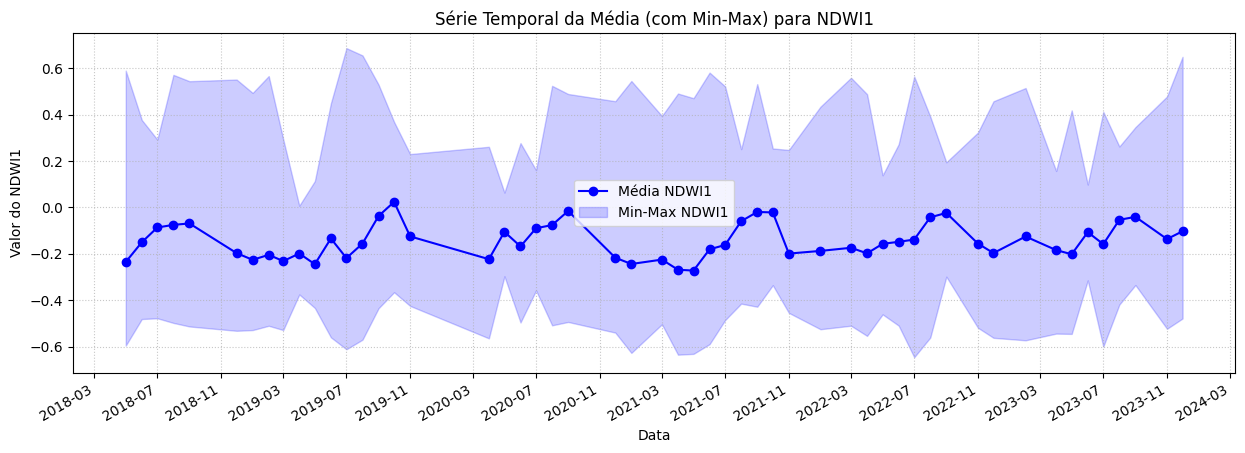

<ipython-input-11-659437c07f9b>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month_name', y='mean', data=df_stats_for_boxplot, order=present_month_names, palette="viridis")


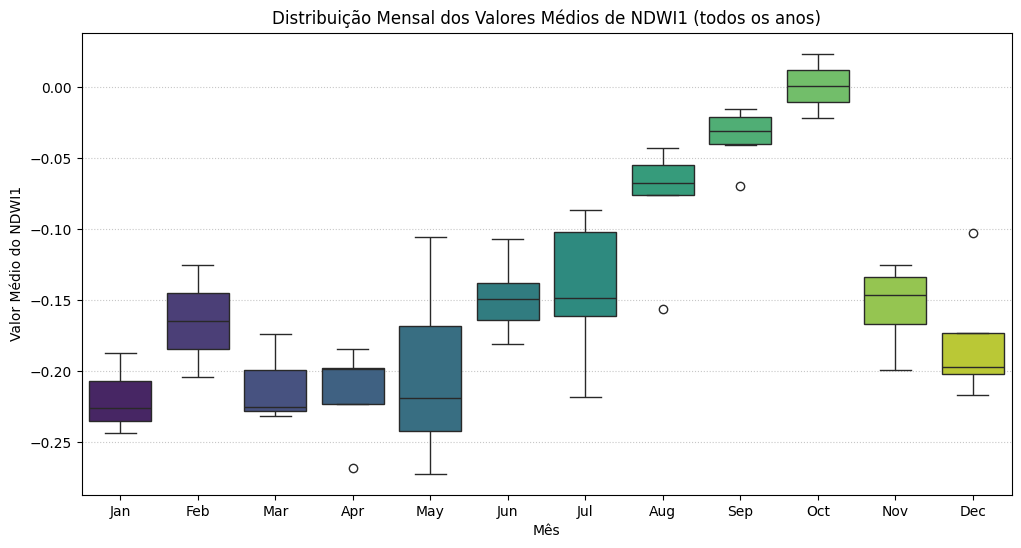



--- Analisando Índice: NDWI2 ---


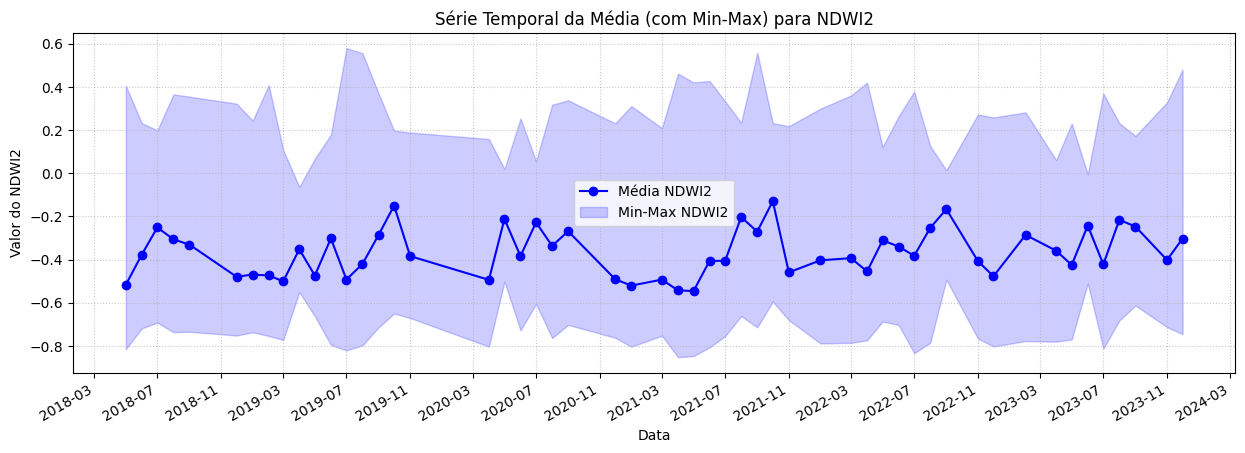

<ipython-input-11-659437c07f9b>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month_name', y='mean', data=df_stats_for_boxplot, order=present_month_names, palette="viridis")


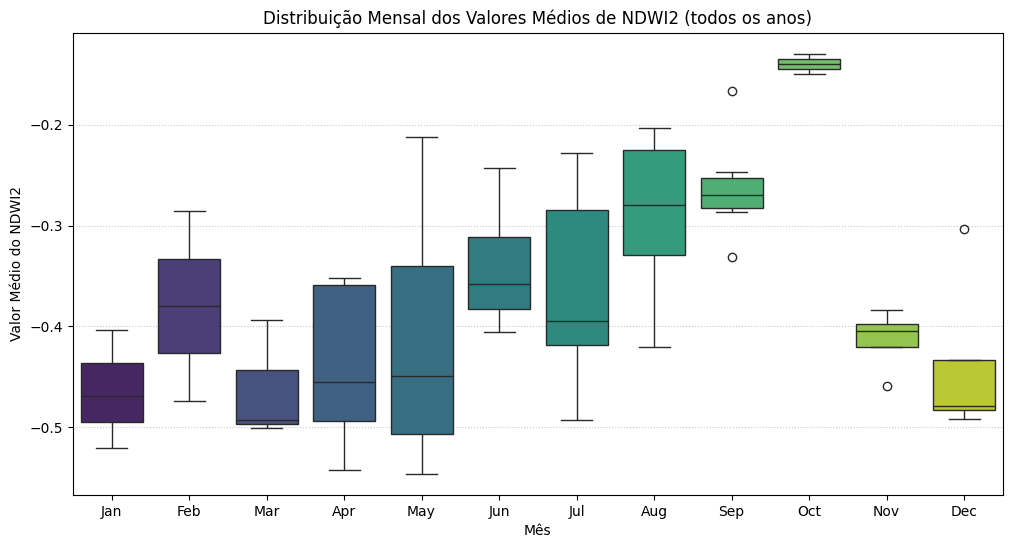



--- Analisando Índice: LNC ---


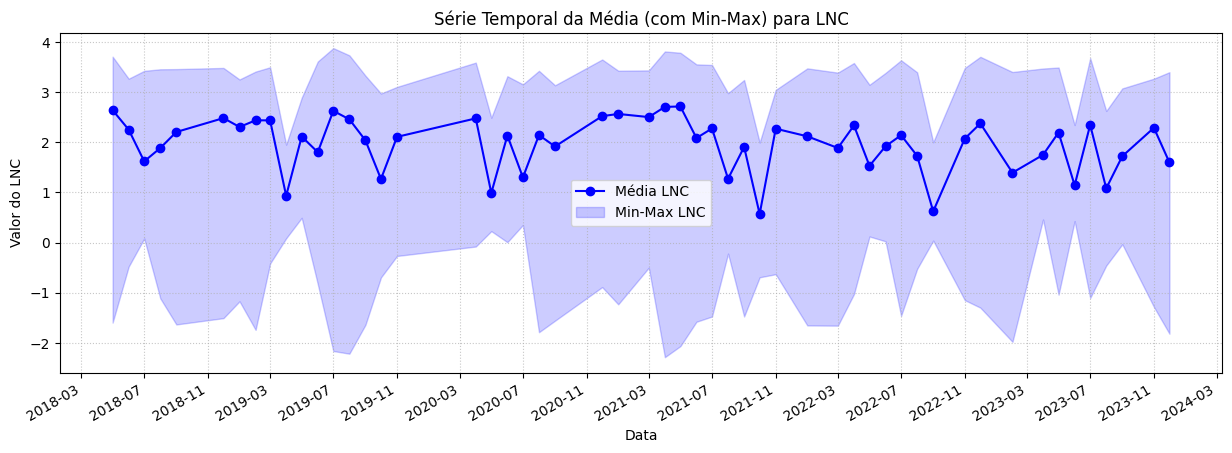

<ipython-input-11-659437c07f9b>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month_name', y='mean', data=df_stats_for_boxplot, order=present_month_names, palette="viridis")


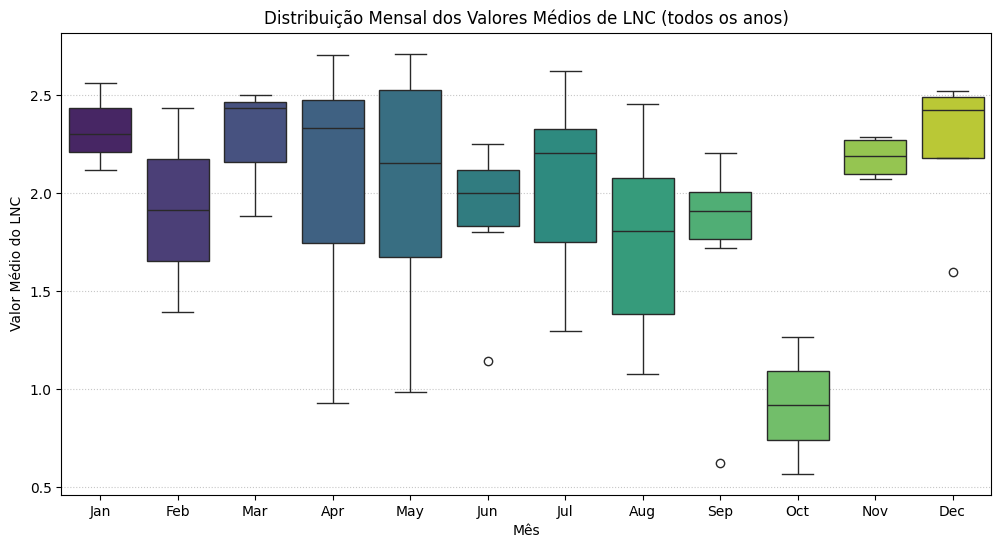



--- Analisando Índice: MCARI ---


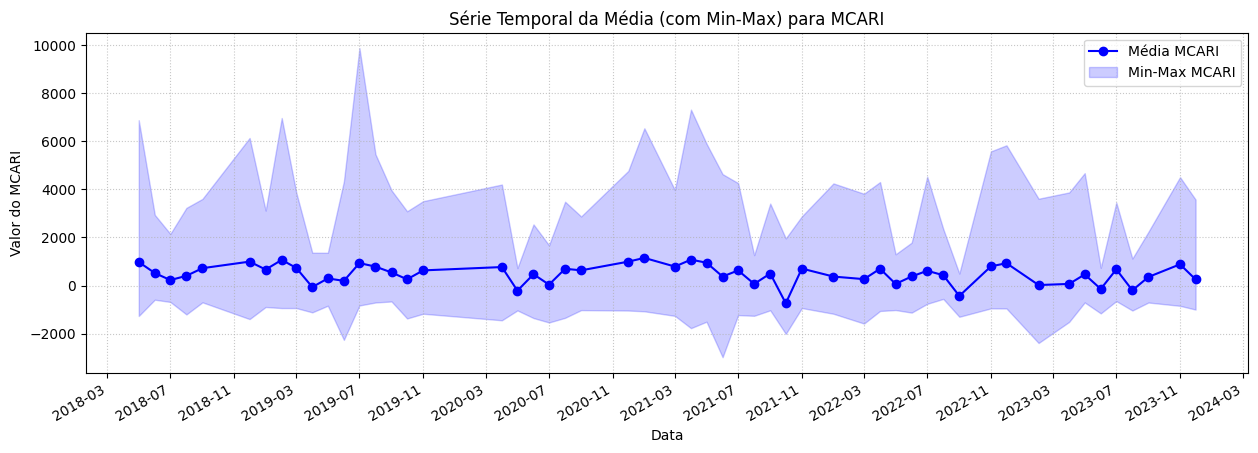

<ipython-input-11-659437c07f9b>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month_name', y='mean', data=df_stats_for_boxplot, order=present_month_names, palette="viridis")


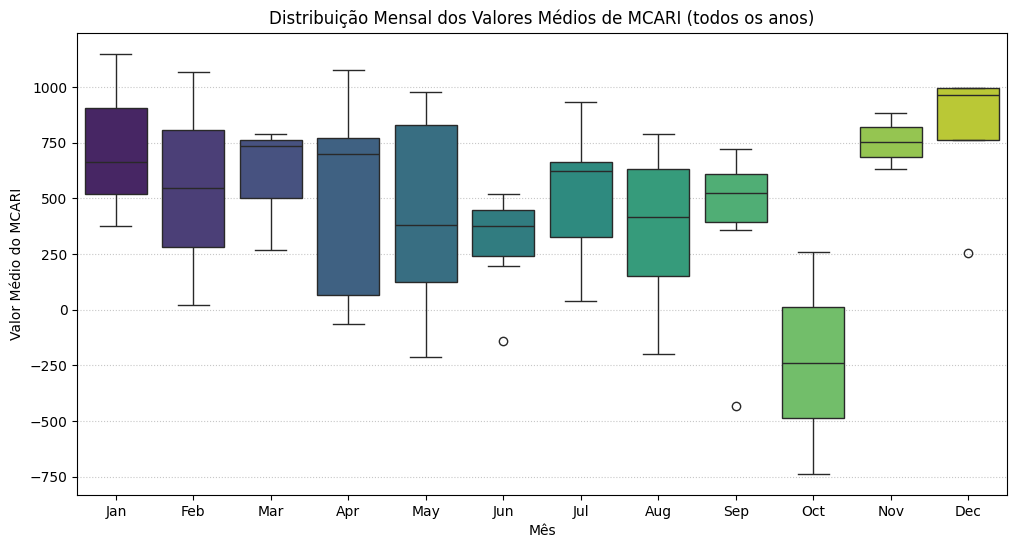



--- Analisando Índice: MCARI1 ---


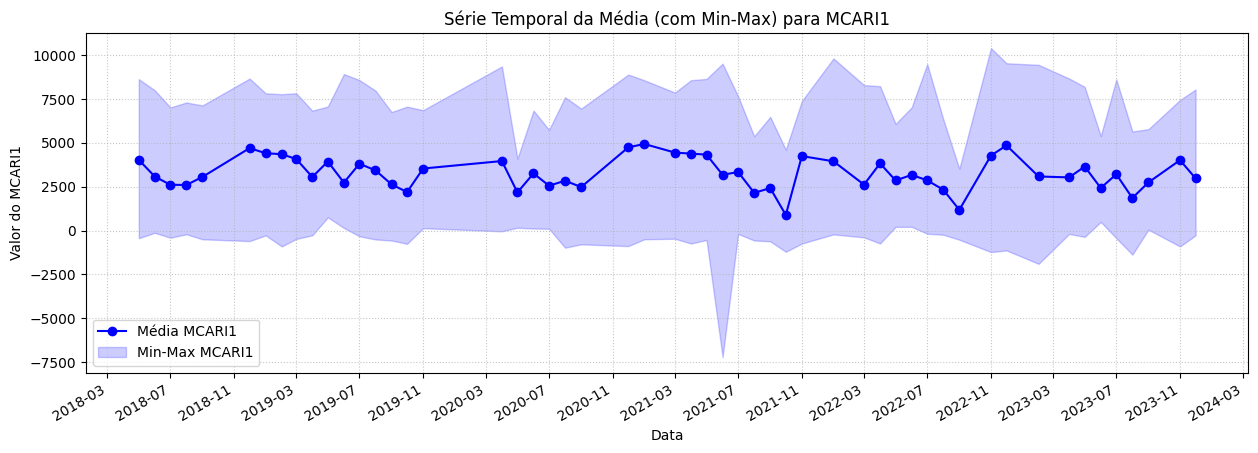

<ipython-input-11-659437c07f9b>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month_name', y='mean', data=df_stats_for_boxplot, order=present_month_names, palette="viridis")


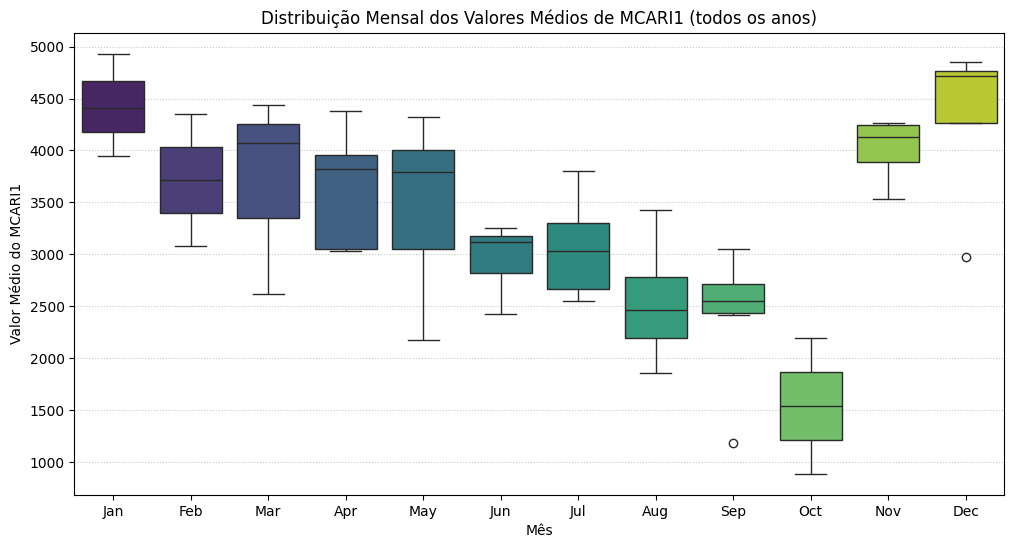



--- Analisando Índice: GOSAVI ---


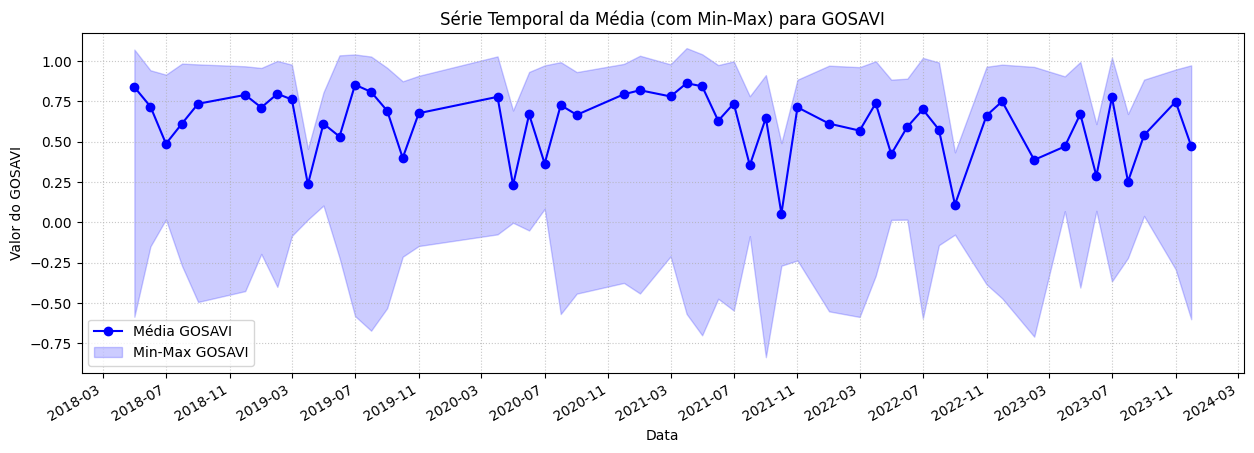

<ipython-input-11-659437c07f9b>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month_name', y='mean', data=df_stats_for_boxplot, order=present_month_names, palette="viridis")


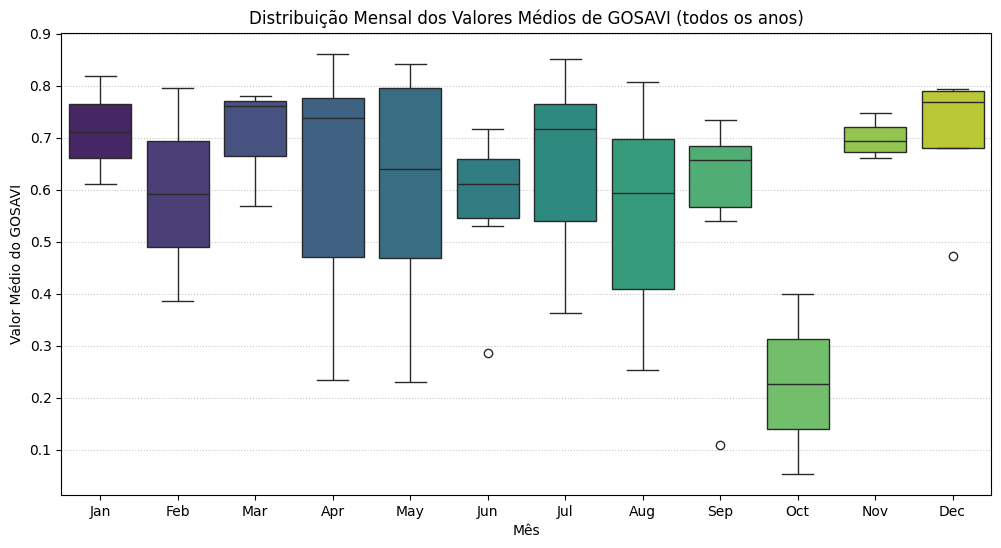


--- Análise de Variação dos Índices Concluída ---


In [11]:
#@title Visualizar Variação dos Índices Originais (Antes do HANTS)

import os
import glob
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns # Para boxplots mais elaborados

# --- Configurações (AJUSTE CONFORME NECESSÁRIO) ---
# Use os caminhos e definições da sua célula de chamada do HANTS
BASE_DRIVE_PATH = "/content/drive/MyDrive/Dissertacao/indices/oasis/openEO" # !!! AJUSTE ESTE CAMINHO !!!

# Lista dos nomes dos índices (nomes das pastas) que você quer analisar
INDICES_PARA_VISUALIZAR = ["NDWI1", "NDWI2", "LNC", "MCARI", "MCARI1", "GOSAVI"] # !!! AJUSTE ESTA LISTA !!!

START_YEAR_VIS = 2018 # !!! AJUSTE !!!
START_MONTH_VIS = 5 # !!! AJUSTE !!!
NUM_YEARS_VIS = 6   # !!! AJUSTE !!!
END_YEAR_VIS = START_YEAR_VIS + NUM_YEARS_VIS - 1
END_MONTH_VIS = 12

# Qualidade da figura
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# --- Função para Ler Estatísticas de um Raster ---
def get_raster_stats(file_path):
    try:
        with rasterio.open(file_path) as src:
            data = src.read(1).astype(np.float32)
            nodata_val = src.nodatavals[0]

            if nodata_val is not None:
                if np.isnan(nodata_val): # Se NoData for NaN
                    valid_data = data[~np.isnan(data)]
                else: # Se NoData for um número
                    valid_data = data[~np.isclose(data, nodata_val) & ~np.isnan(data)] # Adiciona checagem de NaN também
            else: # Se não há NoData definido, considera todos os não-NaN como válidos
                valid_data = data[~np.isnan(data)]

            if valid_data.size > 0:
                return {
                    "mean": np.mean(valid_data),
                    "median": np.median(valid_data),
                    "min": np.min(valid_data),
                    "max": np.max(valid_data),
                    "std": np.std(valid_data),
                    "p25": np.percentile(valid_data, 25),
                    "p75": np.percentile(valid_data, 75),
                    "count_valid": valid_data.size,
                    "count_total": data.size
                }
            else:
                return None # Ou um dicionário de NaNs
    except Exception as e:
        print(f"Erro ao ler {file_path}: {e}")
        return None

# --- Loop Principal por Índice ---
for vi_name_vis in INDICES_PARA_VISUALIZAR:
    print(f"\n\n--- Analisando Índice: {vi_name_vis} ---")
    vi_folder_path = os.path.join(BASE_DRIVE_PATH, vi_name_vis)

    if not os.path.isdir(vi_folder_path):
        print(f"Pasta não encontrada para {vi_name_vis}: {vi_folder_path}. Pulando.")
        continue

    all_stats = []
    all_dates = []

    # Gerar a sequência de datas esperada
    expected_dates_vis = pd.date_range(
        start=f"{START_YEAR_VIS}-{START_MONTH_VIS:02d}-01",
        end=f"{END_YEAR_VIS}-{END_MONTH_VIS:02d}-01",
        freq='MS' # Início do Mês
    )

    for date_obj in expected_dates_vis:
        year_str = date_obj.strftime('%Y')
        month_str = date_obj.strftime('%m')
        # Ajuste para o seu formato de nome de arquivo (com hífen)
        expected_file_name = f"{vi_name_vis}_{year_str}-{month_str}.tif"
        file_path = os.path.join(vi_folder_path, expected_file_name)

        if os.path.exists(file_path):
            stats = get_raster_stats(file_path)
            if stats:
                all_stats.append(stats)
                all_dates.append(date_obj)
        else:
            # print(f"Arquivo não encontrado para {vi_name_vis} em {date_obj.strftime('%Y-%m')}")
            # Adicionar um placeholder para manter a sequência temporal para o plot de linha
            # ou simplesmente pular para o boxplot se for melhor não ter lacunas no plot de linha
            # Por enquanto, vamos apenas adicionar os dados existentes
            pass

    if not all_stats:
        print(f"Nenhum dado válido encontrado para o índice {vi_name_vis}.")
        continue

    df_stats = pd.DataFrame(all_stats)
    df_stats['date'] = pd.to_datetime(all_dates)
    df_stats = df_stats.sort_values(by='date').set_index('date')

    # 1. Gráfico de Linha da Média Temporal (e min/max como sombra)
    plt.figure()
    plt.plot(df_stats.index, df_stats['mean'], label=f'Média {vi_name_vis}', color='blue', marker='o', linestyle='-')
    plt.fill_between(df_stats.index, df_stats['min'], df_stats['max'], color='blue', alpha=0.2, label=f'Min-Max {vi_name_vis}')
    # Alternativa para P25-P75
    # plt.fill_between(df_stats.index, df_stats['p25'], df_stats['p75'], color='skyblue', alpha=0.4, label=f'IQR {vi_name_vis}')

    plt.title(f'Série Temporal da Média (com Min-Max) para {vi_name_vis}')
    plt.xlabel('Data')
    plt.ylabel(f'Valor do {vi_name_vis}')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    # Formatar eixo X para mostrar datas de forma legível
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(df_stats)//12))) # Ajustar intervalo dos ticks
    plt.gcf().autofmt_xdate() # Rotacionar datas para não sobrepor
    plt.show()

    # 2. Boxplot da Distribuição por Mês do Ano
    # Adicionar colunas de ano e mês para agrupamento
    df_stats_for_boxplot = df_stats.copy() # Evitar SettingWithCopyWarning
    df_stats_for_boxplot['year'] = df_stats_for_boxplot.index.year
    df_stats_for_boxplot['month'] = df_stats_for_boxplot.index.month
    df_stats_for_boxplot['month_name'] = df_stats_for_boxplot.index.strftime('%b') # Nome abreviado do mês

    # Ordenar os meses corretamente para o boxplot
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    # Filtrar para garantir que apenas meses presentes nos dados sejam usados para ordenação
    present_month_names = [m for m in month_order if m in df_stats_for_boxplot['month_name'].unique()]


    plt.figure(figsize=(12, 6)) # Ajustar tamanho se necessário
    sns.boxplot(x='month_name', y='mean', data=df_stats_for_boxplot, order=present_month_names, palette="viridis")
    # Você também pode plotar 'median' ou outros se preferir
    plt.title(f'Distribuição Mensal dos Valores Médios de {vi_name_vis} (todos os anos)')
    plt.xlabel('Mês')
    plt.ylabel(f'Valor Médio do {vi_name_vis}')
    plt.grid(True, linestyle=':', axis='y', alpha=0.7)
    plt.show()

    # Opcional: Boxplot por data individual (se não houver muitas datas, pode ser útil)
    if len(df_stats) < 30: # Só se for um número gerenciável de boxplots
        plt.figure(figsize=(max(15, len(df_stats)*0.5) , 6)) # Ajustar largura dinamicamente
        df_stats_for_boxplot['date_str'] = df_stats_for_boxplot.index.strftime('%Y-%m')
        sns.boxplot(x='date_str', y='mean', data=df_stats_for_boxplot, palette="coolwarm")
        plt.title(f'Distribuição dos Valores Médios de {vi_name_vis} por Data')
        plt.xlabel('Data')
        plt.ylabel(f'Valor Médio do {vi_name_vis}')
        plt.xticks(rotation=45, ha="right")
        plt.grid(True, linestyle=':', axis='y', alpha=0.7)
        plt.tight_layout() # Ajustar layout para caber os labels
        plt.show()

print("\n--- Análise de Variação dos Índices Concluída ---")

In [ ]:
#@title 5. Definir Parâmetros e Chamar run_HANTS (ATUALIZADO)

import sys
if '/content/hants' not in sys.path:
    sys.path.insert(0, '/content/hants')

import hants_main_runner # Script atualizado pela Célula 3
from osgeo import gdal, osr # osr precisa ser importado para srs_obj_ref.ImportFromWkt()
import numpy as np
import os
import pandas as pd
import warnings

# --- 1. Definir Parâmetros Específicos para Seus Dados ---
VI_NAME = "MCARI" # Altere para o índice que quer processar
RASTERS_PATH_INPUT = f"/content/drive/MyDrive/Dissertacao/indices/oasis/openEO/{VI_NAME}" # !!! AJUSTE O CAMINHO !!!
BASE_TEMP_COLAB_OUTPUT = "/content/hants_processing_temp" # Pasta temporária no Colab
os.makedirs(BASE_TEMP_COLAB_OUTPUT, exist_ok=True)

NC_FILENAME = f"{VI_NAME}_hants_intermediate.nc"
NC_PATH_PROCESSING = os.path.join(BASE_TEMP_COLAB_OUTPUT, NC_FILENAME) # Salva NetCDF no Colab para velocidade

RASTERS_PATH_OUTPUT_ON_DRIVE = f"/content/drive/MyDrive/Dissertacao/indices/HANTS/oasis/{VI_NAME}" # !!! AJUSTE O CAMINHO !!!
os.makedirs(RASTERS_PATH_OUTPUT_ON_DRIVE, exist_ok=True)

START_DATE_STR = '2018-05-01' # !!! AJUSTE !!!
END_DATE_STR = '2025-05-30'   # !!! AJUSTE !!!

try:
    example_tif_files = [os.path.join(RASTERS_PATH_INPUT, f) for f in os.listdir(RASTERS_PATH_INPUT) if f.lower().endswith('.tif')]
    if not example_tif_files:
        raise FileNotFoundError(f"Nenhum arquivo .tif encontrado em {RASTERS_PATH_INPUT} para usar como referência.")
    EXAMPLE_RASTER_PATH = example_tif_files[0]
    print(f"Usando raster de referência para grade: {EXAMPLE_RASTER_PATH}")

    src_ds = gdal.Open(EXAMPLE_RASTER_PATH)
    if src_ds is None: raise Exception(f"Não foi possível abrir: {EXAMPLE_RASTER_PATH}")
    gt = src_ds.GetGeoTransform()
    srs_wkt = src_ds.GetProjectionRef()
    srs_obj_ref = osr.SpatialReference()
    srs_obj_ref.ImportFromWkt(srs_wkt)

    # Tenta obter o código EPSG
    epsg_code = None
    if srs_obj_ref.IsProjected():
        epsg_code_try = srs_obj_ref.GetAuthorityCode("PROJCS")
        if epsg_code_try: epsg_code = int(epsg_code_try)
    elif srs_obj_ref.IsGeographic():
        epsg_code_try = srs_obj_ref.GetAuthorityCode("GEOGCS")
        if epsg_code_try: epsg_code = int(epsg_code_try)

    EPSG = epsg_code if epsg_code else 4326 # Default WGS84 se não encontrar
    if epsg_code is None:
        warnings.warn(f"Não foi possível determinar o código EPSG do raster de referência. Usando default {EPSG}. Isso pode estar incorreto.")

    CELLSIZE = gt[1]
    LONLIM = [gt[0], gt[0] + src_ds.RasterXSize * gt[1]]
    LATLIM = [gt[3] + src_ds.RasterYSize * gt[5], gt[3]]
    src_ds = None
    print(f"Grade derivada: EPSG={EPSG}, Cellsize={CELLSIZE}, Lonlim={LONLIM}, Latlim={LATLIM}")

except Exception as e:
    print(f"Erro ao derivar parâmetros da grade: {e}")
    print("Defina LONLIM, LATLIM, CELLSIZE, EPSG manualmente se necessário.")

NB = 12; NF = 6; HILO = 'Lo'; LOW_VALID = -1000; HIGH_VALID = 1000            # Configurações LNC:  NF = 6; LOW_VALID = 0.0, HIGH_VALID = 2.0, FET = 0.1 # MCARI: NF = 6; LOW_VALID = -1000; HIGH_VALID = 1000; FET = 0.2
FET = 0.2; DOD = 1; DELTA = 0.1; FILL_VAL = -9999.0                       # MCARI1: NF = 6; LOW_VALID = 0; HIGH_VALID = 4000; FET = 0.2
EXPORT_HANTS_ONLY = False
# Template para nome de arquivo de saída: {0} é o VI_NAME, {1} é a data YYYYMMDD
OUTPUT_FILENAME_TEMPLATE_FOR_EXPORT = "{0}_HANTS_{1}.tif"

# --- Chamar a Função run_HANTS ---
if 'LONLIM' not in locals(): # Verifica se os parâmetros da grade foram definidos
    print("ERRO: Parâmetros da grade (LONLIM, etc.) não definidos. Abortando.")
else:
    try:
        print(f"Iniciando processamento HANTS para o índice: {VI_NAME}")
        hants_main_runner.run_HANTS(
            rasters_path_inp=RASTERS_PATH_INPUT,
            vi_name_for_files=VI_NAME, # Passa o nome do índice aqui
            start_date=START_DATE_STR,
            end_date=END_DATE_STR,
            latlim=LATLIM,
            lonlim=LONLIM,
            cellsize=CELLSIZE,
            nc_path=NC_PATH_PROCESSING, # Salva NetCDF no ambiente Colab
            nb=NB, nf=NF, HiLo=HILO, low=LOW_VALID, high=HIGH_VALID,
            fet=FET, dod=DOD, delta=DELTA, epsg=EPSG, fill_val=FILL_VAL,
            rasters_path_out=RASTERS_PATH_OUTPUT_ON_DRIVE, # Salva TIFFs no Drive
            export_hants_only=EXPORT_HANTS_ONLY,
            output_filename_template=OUTPUT_FILENAME_TEMPLATE_FOR_EXPORT
        )
        print(f"Processamento HANTS para {VI_NAME} concluído!")
        print(f"NetCDF intermediário: {NC_PATH_PROCESSING}")
        if RASTERS_PATH_OUTPUT_ON_DRIVE:
            print(f"GeoTIFFs reconstruídos: {RASTERS_PATH_OUTPUT_ON_DRIVE}")

    except FileNotFoundError as e_fnf: print(f"ERRO DE ARQUIVO: {e_fnf}.")
    except NameError as e_name: print(f"ERRO DE NOME: {e_name}.")
    except ValueError as e_val: print(f"ERRO DE VALOR: {e_val}.")
    except ImportError as e_imp: print(f"ERRO DE IMPORTAÇÃO: {e_imp}.")
    except Exception as e:
        print(f"UM ERRO INESPERADO OCORREU: {e}")
        import traceback
        traceback.print_exc()

Usando raster de referência para grade: /content/drive/MyDrive/Dissertacao/indices/oasis/openEO/MCARI/MCARI_2018-05.tif
Grade derivada: EPSG=32723, Cellsize=10.0, Lonlim=[726010.0, 727100.0], Latlim=[7692030.0, 7693130.0]
Iniciando processamento HANTS para o índice: MCARI
[run_HANTS] Iniciando para índice: MCARI em: /content/drive/MyDrive/Dissertacao/indices/oasis/openEO/MCARI
  [create_netcdf] Iniciando para índice 'MCARI' em /content/drive/MyDrive/Dissertacao/indices/oasis/openEO/MCARI
  [create_netcdf] Período: 2018-05-01 a 2025-05-30
  [create_netcdf] Grade NetCDF: 110 lats, 109 lons. Cellsize: 10.0
  [create_netcdf] Datas mensais para NetCDF (85): 2018-05 a 2025-05
  [create_netcdf] Criando arquivo NetCDF: /content/hants_processing_temp/MCARI_hants_intermediate.nc ...
    [create_netcdf] Variáveis NetCDF criadas.
    [create_netcdf] Extraindo dados dos rasters...
      [create_netcdf] Procurando por: /content/drive/MyDrive/Dissertacao/indices/oasis/openEO/MCARI/MCARI_2018-05.tif
 

In [ ]:
#@title Célula de Inspeção do NetCDF (Gráficos temporais)
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para converter datas do NetCDF

# Use a variável NC_PATH_PROCESSING da sua célula de chamada do HANTS
nc_file_path = NC_PATH_PROCESSING

FILL_VAL = -9999.0 # O valor de preenchimento que você usou

try:
    with netCDF4.Dataset(nc_file_path, 'r') as nc_ds:
        print(f"--- Inspecionando NetCDF: {nc_file_path} ---")
        print(f"Variáveis disponíveis: {list(nc_ds.variables.keys())}")

        if 'original_values' not in nc_ds.variables:
            print("ERRO: Variável 'original_values' não encontrada no NetCDF!")
        else:
            original_data = nc_ds.variables['original_values'][:]
            print(f"\nShape de 'original_values': {original_data.shape}")

            # Verificar se há algo além do fill_val
            data_not_fill_val = original_data[~np.isclose(original_data, FILL_VAL)]
            if data_not_fill_val.size > 0:
                print(f"  Valores em 'original_values' (excluindo fill_val={FILL_VAL}):")
                print(f"    Mínimo: {np.min(data_not_fill_val):.4f}")
                print(f"    Máximo: {np.max(data_not_fill_val):.4f}")
                print(f"    Média: {np.mean(data_not_fill_val):.4f}")
                unique_valid_vals = np.unique(data_not_fill_val)
                print(f"    Valores únicos válidos (amostra): {unique_valid_vals[:min(10, len(unique_valid_vals))]}...")
            else:
                print(f"  AVISO: Todos os valores em 'original_values' parecem ser o fill_val ({FILL_VAL}).")
                unique_vals = np.unique(original_data)
                print(f"  Valores únicos encontrados em 'original_values': {unique_vals}")


        if 'hants_values' in nc_ds.variables:
            hants_data = nc_ds.variables['hants_values'][:]
            print(f"\nShape de 'hants_values': {hants_data.shape}")
            data_not_fill_val_hants = hants_data[~np.isclose(hants_data, FILL_VAL)]
            if data_not_fill_val_hants.size > 0 and not np.all(np.isclose(data_not_fill_val_hants, 0.0)):
                print(f"  Valores em 'hants_values' (excluindo fill_val={FILL_VAL} e zeros):")
                non_zero_hants = data_not_fill_val_hants[~np.isclose(data_not_fill_val_hants, 0.0)]
                if non_zero_hants.size > 0:
                    print(f"    Mínimo: {np.min(non_zero_hants):.4f}")
                    print(f"    Máximo: {np.max(non_zero_hants):.4f}")
                    print(f"    Média: {np.mean(non_zero_hants):.4f}")
                else:
                    print("    Todos os valores em 'hants_values' (não fill_val) são zero.")
            else:
                print(f"  AVISO: Todos os valores em 'hants_values' parecem ser o fill_val ({FILL_VAL}) ou zero.")
                unique_vals_hants = np.unique(hants_data)
                print(f"  Valores únicos encontrados em 'hants_values': {unique_vals_hants}")

        # Plotar série temporal de um pixel central para diagnóstico
        if 'original_values' in nc_ds.variables and 'hants_values' in nc_ds.variables and 'time' in nc_ds.variables:
            lat_n, lon_n, time_n = original_data.shape
            r_plot, c_plot = lat_n // 2, lon_n // 2 # Pixel central

            time_numeric = nc_ds.variables['time'][:]
            try:
                time_datetime = [pd.to_datetime(str(int(t)), format='%Y%m%d') for t in time_numeric]
            except:
                time_datetime = np.arange(len(time_numeric)) # Fallback para índice se conversão falhar

            plt.figure(figsize=(12, 6))
            plt.plot(time_datetime, original_data[r_plot, c_plot, :], 'b.-', label=f'Original Pixel ({r_plot},{c_plot})')
            plt.plot(time_datetime, hants_data[r_plot, c_plot, :], 'r.-', label=f'HANTS Pixel ({r_plot},{c_plot})')
            plt.title(f"Série Temporal Original vs HANTS - Pixel ({r_plot},{c_plot})")
            plt.xlabel("Tempo")
            plt.ylabel("Valor do Índice")
            plt.legend()
            plt.grid(True)
            plt.ylim(0, 6000) # Ajuste este ylim para a faixa esperada do seu índice
            plt.show()


except Exception as e:
    print(f"Erro ao ler o arquivo NetCDF: {e}")
    print(f"Verifique se a variável NC_PATH_PROCESSING ('{NC_PATH_PROCESSING}') está correta e o arquivo existe.")

ERRO: Uma ou mais variáveis de configuração não estão definidas: name 'START_YEAR' is not defined
Certifique-se de que VI_NAME, RASTERS_PATH_OUTPUT_ON_DRIVE, START_YEAR, NUM_YEARS estão definidos.

--- Calculando Variância Temporal Mensal por Pixel para MCARI1 (Após HANTS) ---
Lendo arquivos de: /content/drive/MyDrive/Dissertacao/indices/HANTS/oasis/MCARI1


  Processando Mês: January (5 anos de dados)


  Processando Mês: February (5 anos de dados)


  Processando Mês: March (5 anos de dados)


  Processando Mês: April (5 anos de dados)


  Processando Mês: May (6 anos de dados)


  Processando Mês: June (6 anos de dados)


  Processando Mês: July (6 anos de dados)


  Processando Mês: August (6 anos de dados)


  Processando Mês: September (6 anos de dados)


  Processando Mês: October (6 anos de dados)


  Processando Mês: November (6 anos de dados)


  Processando Mês: December (6 anos de dados)


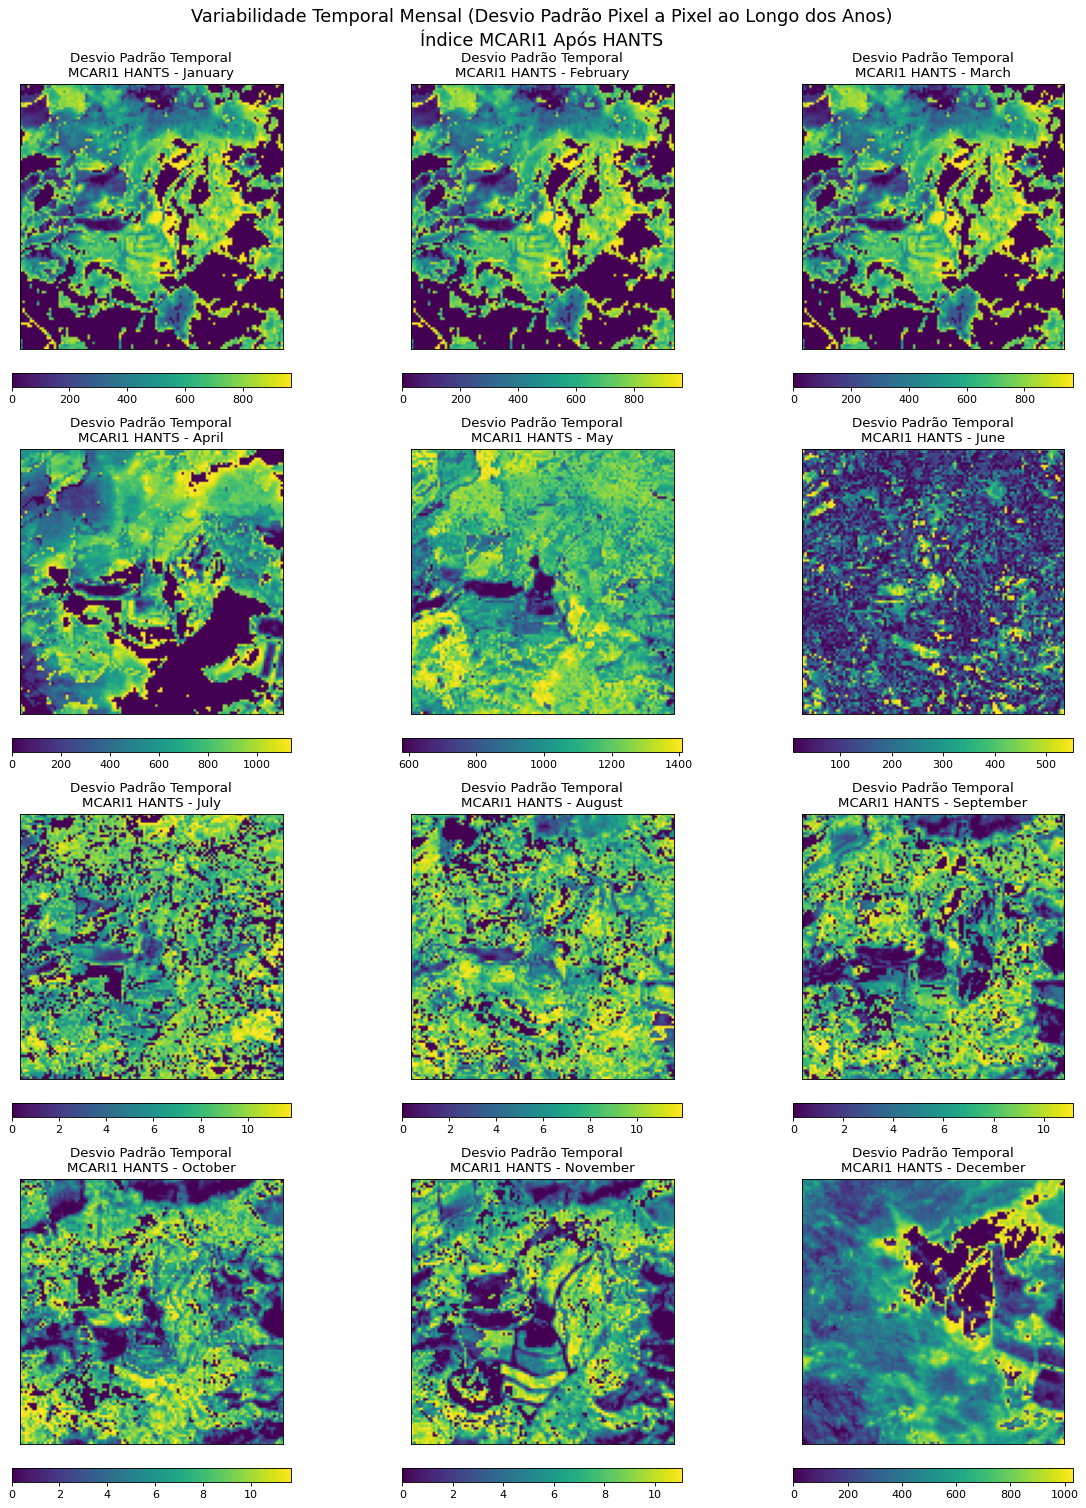


--- Visualização da Variância Temporal Mensal Concluída ---


In [13]:
#@title Calcular e Visualizar Variância Temporal Mensal por Pixel (Após HANTS)

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# --- Configurações (AJUSTE CONFORME NECESSÁRIO) ---
# Use os caminhos e definições da sua célula de chamada do HANTS
# VI_NAME, RASTERS_PATH_OUTPUT_ON_DRIVE, START_YEAR, NUM_YEARS
# já devem estar definidos. Se não, defina-os aqui.

# Exemplo (certifique-se de que estas variáveis estão definidas na sua sessão):
#VI_NAME = "LNC"
RASTERS_PATH_OUTPUT_ON_DRIVE = f"/content/drive/MyDrive/Dissertacao/indices/HANTS/oasis/{VI_NAME}"
# START_YEAR = 2018
# NUM_YEARS = 6

# Qualidade da figura
plt.rcParams['figure.figsize'] = [20, 15] # Ajuste para comportar 12 mapas (ex: 4 linhas, 3 colunas)
plt.rcParams['figure.dpi'] = 80

# --- Verificar se as variáveis de configuração existem ---
try:
    _ = VI_NAME
    _ = RASTERS_PATH_OUTPUT_ON_DRIVE
    _ = START_YEAR
    _ = NUM_YEARS
except NameError as e:
    print(f"ERRO: Uma ou mais variáveis de configuração não estão definidas: {e}")
    print("Certifique-se de que VI_NAME, RASTERS_PATH_OUTPUT_ON_DRIVE, START_YEAR, NUM_YEARS estão definidos.")
    # Você pode definir valores placeholder aqui para testar a célula, mas ajuste-os!
    # VI_NAME = "NDVI"
    # RASTERS_PATH_OUTPUT_ON_DRIVE = f"/content/drive/MyDrive/TEMP/openEO_HANTS_output/{VI_NAME}"
    # os.makedirs(RASTERS_PATH_OUTPUT_ON_DRIVE, exist_ok=True)
    START_YEAR = 2018
    NUM_YEARS = 6


print(f"\n--- Calculando Variância Temporal Mensal por Pixel para {VI_NAME} (Após HANTS) ---")
print(f"Lendo arquivos de: {RASTERS_PATH_OUTPUT_ON_DRIVE}")

# 1. Agrupar arquivos HANTS por mês do ano
monthly_files = defaultdict(list) # Dicionário para armazenar listas de arquivos por mês (1-12)
profile = None # Para armazenar o perfil geoespacial do primeiro raster lido

# Gerar todas as datas mensais do período para encontrar os arquivos
all_expected_dates = pd.date_range(
    start=f"{START_YEAR}-01-01",
    periods=NUM_YEARS * 12, # 6 anos * 12 meses
    freq='MS'
)

for date_obj in all_expected_dates:
    year_str = date_obj.strftime('%Y')
    month_num = date_obj.month # Número do mês (1-12)
    # O HANTS exporta com YYYYMMDD, usando o primeiro dia do mês
    date_str_for_filename = date_obj.strftime('%Y%m%d')

    # Nome do arquivo HANTS esperado
    # (baseado na lógica de export_tiffs em hants_main_runner.py: f"{vi_name}_HANTS_{date_str_for_filename}.tif")
    filename = f"{VI_NAME}_HANTS_{date_str_for_filename}.tif"
    file_path = os.path.join(RASTERS_PATH_OUTPUT_ON_DRIVE, filename)

    if os.path.exists(file_path):
        monthly_files[month_num].append(file_path)
        if profile is None: # Pega o perfil do primeiro arquivo encontrado
            with rasterio.open(file_path) as src_template:
                profile = src_template.profile
                nodata_val_template = src_template.nodatavals[0]
    # else:
        # print(f"Arquivo não encontrado (esperado para HANTS): {file_path}")


if profile is None:
    print(f"ERRO: Nenhum arquivo HANTS encontrado em {RASTERS_PATH_OUTPUT_ON_DRIVE}. Verifique o caminho e os nomes dos arquivos.")
else:
    height = profile['height']
    width = profile['width']

    # 2. Calcular a variância temporal para cada mês e plotar
    # (ex: 4 linhas, 3 colunas para 12 meses)
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    axes = axes.ravel()

    plot_idx = 0
    for month_num in range(1, 13): # Iterar de Janeiro (1) a Dezembro (12)
        ax = axes[plot_idx]
        month_name = pd.Timestamp(f"2000-{month_num}-01").strftime('%B') # Nome do mês por extenso

        if month_num in monthly_files and len(monthly_files[month_num]) > 1: # Precisa de pelo menos 2 observações para variância
            files_for_month = monthly_files[month_num]
            print(f"  Processando Mês: {month_name} ({len(files_for_month)} anos de dados)")

            # Empilhar os dados do mesmo mês de diferentes anos
            # Lista para armazenar os arrays 2D de cada ano para este mês
            month_yearly_data_list = []
            for f_path in files_for_month:
                try:
                    with rasterio.open(f_path) as src:
                        data = src.read(1).astype(np.float32)
                        # Lidar com NoData (substituir por NaN para cálculo da variância)
                        current_nodata = src.nodatavals[0] if src.nodatavals[0] is not None else nodata_val_template
                        if current_nodata is not None:
                            if np.isnan(current_nodata):
                                data[np.isnan(data)] = np.nan
                            else:
                                data[np.isclose(data, current_nodata)] = np.nan
                        month_yearly_data_list.append(data)
                except Exception as e:
                    print(f"    Erro ao ler {f_path} para o mês {month_name}: {e}")

            if len(month_yearly_data_list) > 1: # Se conseguiu ler pelo menos 2 camadas
                # Criar um stack 3D (anos, altura, largura)
                month_stack_3d = np.stack(month_yearly_data_list, axis=0)

                # Calcular o desvio padrão ao longo do eixo do tempo (anos) para cada pixel
                # np.nanstd calcula o desvio padrão ignorando NaNs
                variance_map_for_month = np.nanstd(month_stack_3d, axis=0)
                # Se quiser a variância em vez do desvio padrão:
                # variance_map_for_month = np.nanvar(month_stack_3d, axis=0)

                # Visualizar o mapa de variância (ou desvio padrão)
                # Determinar vmin e vmax para a colorbar de forma robusta
                valid_variance_pixels = variance_map_for_month[~np.isnan(variance_map_for_month)]
                if valid_variance_pixels.size > 0:
                    vmin_plot = np.percentile(valid_variance_pixels, 2)  # Ignora os 2% menores
                    vmax_plot = np.percentile(valid_variance_pixels, 98) # Ignora os 2% maiores
                    if vmin_plot == vmax_plot : # Se todos os valores forem iguais
                        vmin_plot = vmax_plot - 0.01 if vmax_plot > 0 else -0.01
                        vmax_plot = vmax_plot + 0.01 if vmax_plot > 0 else  0.01
                        if vmin_plot == vmax_plot : vmax_plot = vmin_plot + 0.001 # fallback final

                else:
                    vmin_plot, vmax_plot = 0, 0.1 # Default se não houver dados válidos

                img_plot = ax.imshow(variance_map_for_month, cmap='viridis', vmin=vmin_plot, vmax=vmax_plot)
                ax.set_title(f"Desvio Padrão Temporal\n{VI_NAME} HANTS - {month_name}")
                fig.colorbar(img_plot, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
            else:
                ax.set_title(f"{VI_NAME} HANTS - {month_name}\n(Dados insuficientes)")
                ax.text(0.5, 0.5, "Dados insuficientes (<2 anos)", transform=ax.transAxes, ha='center', va='center')

        else: # Se não há arquivos para este mês ou apenas 1 arquivo
            ax.set_title(f"{VI_NAME} HANTS - {month_name}\n(Sem dados ou <2 anos)")
            ax.text(0.5, 0.5, "Sem dados ou <2 anos", transform=ax.transAxes, ha='center', va='center')

        ax.set_xticks([])
        ax.set_yticks([])
        plot_idx += 1

    # Ocultar eixos extras se houver menos de 12 plots (improvável aqui)
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.05, 1, 0.97]) # Ajustar para o suptitle e colorbars
    plt.suptitle(f"Variabilidade Temporal Mensal (Desvio Padrão Pixel a Pixel ao Longo dos Anos)\nÍndice {VI_NAME} Após HANTS", fontsize=16, y=0.99)
    plt.show()

print("\n--- Visualização da Variância Temporal Mensal Concluída ---")